In [1]:
3+6

9

# Master File

# Tools & Libraries

In [2]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
print(file_dir)
parent_dir = file_dir.parent
print(parent_dir)
sys.path.append(str(parent_dir))

C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython\vkprog_analyse
C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython


In [6]:
%load_ext autoreload
%autoreload
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pa_lib.vis import (boxplot_histogram)

from pa_lib.file import (
    project_dir,
    load_bin,
    load_csv,
    load_xlsx,
    store_bin
    )


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from pa_lib.data import desc_col

In [8]:
from IPython.display import display
pd.options.display.max_columns = None


In [9]:
# Lazy Recursive Job Dependency Request:
from pa_lib.job import request_job

################################################################################
## Recursive Dependency Check:
request_job(
    job_name= "ek_info_prepare.py",
    #current = "This Week",
    current = "Today"
    ) 
# output: ek_info.feather

16:25:26 [INFO] [ipykernel_launcher.py] requests 'ek_info_prepare.py'
16:25:26 [INFO] [ipykernel_launcher.py]: Not running job 'ek_info_prepare.py': result is current ('Today') from 2019-11-19 15:31:59.715109.


# Load Dataset (Data Preparation)

In [10]:
from vkprog_data_prep import bd_train_scoring


16:25:28 [INFO] [ipykernel_launcher.py] requests 'bd_prepare.py'
16:25:28 [INFO] [ipykernel_launcher.py]: Not running job 'bd_prepare.py': result is current ('Today') from 2019-11-19 10:05:43.975174.


http://www.whatweekisit.org/

In [15]:
%%time
# Wall time: 38.5 s

# 2019-10-21 => Calendar week 43
(training_all,
 scoring_all,
 feature_colnames_bd,
 feature_colnames_dates,
 feature_colnames_branchen
    ) = bd_train_scoring(
            day            = 2, # a Monday
            month          = 12,
            year_score     = 2019,
            year_train     = 2018,
            year_span      = 4,
            scale_features = True,
            sales_filter   = True
            #Sales Filter: Keine Langzeitverträge, Eigenwerbung, 
            #              Logistik für Dritte, politisch... etc.
            )

16:25:46 [INFO] Started loading binary file
16:25:46 [INFO] Reading from file C:\Users\stc\data\vkprog\bd_data.feather
16:25:46 [INFO] Finished loading binary file in 0.16s (0.84s CPU)
16:25:48 [INFO] True: Filters applied, defined by Sales
16:25:48 [INFO] Period: KW_2
16:25:48 [INFO] Calculate Reservation...
16:25:49 [INFO] Calculate Aushang...
16:25:49 [INFO] Merge Results...
16:25:49 [INFO] aggregate_bookings: Done.
16:25:49 [INFO] current_yyyykw: 201949
16:25:49 [INFO] date_now:       2019-12-02 00:00:00
16:25:49 [INFO] training_yyyykw:201849
16:25:49 [INFO] date_training:  2018-12-03 00:00:00
16:25:54 [INFO] Scaling features
16:25:56 [INFO] Finished.
Wall time: 10.5 s


In [16]:
print(f"training_all.shape: {training_all.shape}")
print(f"scoring_all.shape: {scoring_all.shape}")
print("\ntraining_all\n")
display(training_all.describe())
print("\nscoring_all\n")
display(scoring_all.describe())

training_all.shape: (12619, 309)
scoring_all.shape: (12697, 309)

training_all



,Endkunde_NR,Erste_Buchung_Delta,Letzte_Buchung_Delta,Erste_Letzte_Buchung_Delta,Netto_Sum_Aus_RY_0_KW_1,Netto_Sum_Aus_RY_0_KW_11,Netto_Sum_Aus_RY_0_KW_13,Netto_Sum_Aus_RY_0_KW_15,Netto_Sum_Aus_RY_0_KW_17,Netto_Sum_Aus_RY_0_KW_19,Netto_Sum_Aus_RY_0_KW_21,Netto_Sum_Aus_RY_0_KW_23,Netto_Sum_Aus_RY_0_KW_25,Netto_Sum_Aus_RY_0_KW_27,Netto_Sum_Aus_RY_0_KW_29,Netto_Sum_Aus_RY_0_KW_3,Netto_Sum_Aus_RY_0_KW_31,Netto_Sum_Aus_RY_0_KW_33,Netto_Sum_Aus_RY_0_KW_35,Netto_Sum_Aus_RY_0_KW_37,Netto_Sum_Aus_RY_0_KW_39,Netto_Sum_Aus_RY_0_KW_41,Netto_Sum_Aus_RY_0_KW_43,Netto_Sum_Aus_RY_0_KW_45,Netto_Sum_Aus_RY_0_KW_47,Netto_Sum_Aus_RY_0_KW_5,Netto_Sum_Aus_RY_0_KW_7,Netto_Sum_Aus_RY_0_KW_9,Netto_Sum_Aus_RY_1_KW_1,Netto_Sum_Aus_RY_1_KW_11,Netto_Sum_Aus_RY_1_KW_13,Netto_Sum_Aus_RY_1_KW_15,Netto_Sum_Aus_RY_1_KW_17,Netto_Sum_Aus_RY_1_KW_19,Netto_Sum_Aus_RY_1_KW_21,Netto_Sum_Aus_RY_1_KW_23,Netto_Sum_Aus_RY_1_KW_25,Netto_Sum_Aus_RY_1_KW_27,Netto_Sum_Aus_RY_1_KW_29,Netto_Sum_Aus_RY_1_KW_3,Netto_Sum_Aus_RY_1_KW_31,Netto_Sum_Aus_RY_1_KW_33,Netto_Sum_Aus_RY_1_KW_35,Netto_Sum_Aus_RY_1_KW_37,Netto_Sum_Aus_RY_1_KW_39,Netto_Sum_Aus_RY_1_KW_41,Netto_Sum_Aus_RY_1_KW_43,Netto_Sum_Aus_RY_1_KW_45,Netto_Sum_Aus_RY_1_KW_47,Netto_Sum_Aus_RY_1_KW_49,Netto_Sum_Aus_RY_1_KW_5,Netto_Sum_Aus_RY_1_KW_51,Netto_Sum_Aus_RY_1_KW_7,Netto_Sum_Aus_RY_1_KW_9,Netto_Sum_Aus_RY_2_KW_1,Netto_Sum_Aus_RY_2_KW_11,Netto_Sum_Aus_RY_2_KW_13,Netto_Sum_Aus_RY_2_KW_15,Netto_Sum_Aus_RY_2_KW_17,Netto_Sum_Aus_RY_2_KW_19,Netto_Sum_Aus_RY_2_KW_21,Netto_Sum_Aus_RY_2_KW_23,Netto_Sum_Aus_RY_2_KW_25,Netto_Sum_Aus_RY_2_KW_27,Netto_Sum_Aus_RY_2_KW_29,Netto_Sum_Aus_RY_2_KW_3,Netto_Sum_Aus_RY_2_KW_31,Netto_Sum_Aus_RY_2_KW_33,Netto_Sum_Aus_RY_2_KW_35,Netto_Sum_Aus_RY_2_KW_37,Netto_Sum_Aus_RY_2_KW_39,Netto_Sum_Aus_RY_2_KW_41,Netto_Sum_Aus_RY_2_KW_43,Netto_Sum_Aus_RY_2_KW_45,Netto_Sum_Aus_RY_2_KW_47,Netto_Sum_Aus_RY_2_KW_49,Netto_Sum_Aus_RY_2_KW_5,Netto_Sum_Aus_RY_2_KW_51,Netto_Sum_Aus_RY_2_KW_7,Netto_Sum_Aus_RY_2_KW_9,Netto_Sum_Aus_RY_3_KW_1,Netto_Sum_Aus_RY_3_KW_11,Netto_Sum_Aus_RY_3_KW_13,Netto_Sum_Aus_RY_3_KW_15,Netto_Sum_Aus_RY_3_KW_17,Netto_Sum_Aus_RY_3_KW_19,Netto_Sum_Aus_RY_3_KW_21,Netto_Sum_Aus_RY_3_KW_23,Netto_Sum_Aus_RY_3_KW_25,Netto_Sum_Aus_RY_3_KW_27,Netto_Sum_Aus_RY_3_KW_29,Netto_Sum_Aus_RY_3_KW_3,Netto_Sum_Aus_RY_3_KW_31,Netto_Sum_Aus_RY_3_KW_33,Netto_Sum_Aus_RY_3_KW_35,Netto_Sum_Aus_RY_3_KW_37,Netto_Sum_Aus_RY_3_KW_39,Netto_Sum_Aus_RY_3_KW_41,Netto_Sum_Aus_RY_3_KW_43,Netto_Sum_Aus_RY_3_KW_45,Netto_Sum_Aus_RY_3_KW_47,Netto_Sum_Aus_RY_3_KW_49,Netto_Sum_Aus_RY_3_KW_5,Netto_Sum_Aus_RY_3_KW_51,Netto_Sum_Aus_RY_3_KW_7,Netto_Sum_Aus_RY_3_KW_9,Netto_Sum_Aus_RY_4_KW_49,Netto_Sum_Aus_RY_4_KW_51,Netto_Sum_Res_RY_0_KW_1,Netto_Sum_Res_RY_0_KW_11,Netto_Sum_Res_RY_0_KW_13,Netto_Sum_Res_RY_0_KW_15,Netto_Sum_Res_RY_0_KW_17,Netto_Sum_Res_RY_0_KW_19,Netto_Sum_Res_RY_0_KW_21,Netto_Sum_Res_RY_0_KW_23,Netto_Sum_Res_RY_0_KW_25,Netto_Sum_Res_RY_0_KW_27,Netto_Sum_Res_RY_0_KW_29,Netto_Sum_Res_RY_0_KW_3,Netto_Sum_Res_RY_0_KW_31,Netto_Sum_Res_RY_0_KW_33,Netto_Sum_Res_RY_0_KW_35,Netto_Sum_Res_RY_0_KW_37,Netto_Sum_Res_RY_0_KW_39,Netto_Sum_Res_RY_0_KW_41,Netto_Sum_Res_RY_0_KW_43,Netto_Sum_Res_RY_0_KW_45,Netto_Sum_Res_RY_0_KW_47,Netto_Sum_Res_RY_0_KW_5,Netto_Sum_Res_RY_0_KW_7,Netto_Sum_Res_RY_0_KW_9,Netto_Sum_Res_RY_1_KW_1,Netto_Sum_Res_RY_1_KW_11,Netto_Sum_Res_RY_1_KW_13,Netto_Sum_Res_RY_1_KW_15,Netto_Sum_Res_RY_1_KW_17,Netto_Sum_Res_RY_1_KW_19,Netto_Sum_Res_RY_1_KW_21,Netto_Sum_Res_RY_1_KW_23,Netto_Sum_Res_RY_1_KW_25,Netto_Sum_Res_RY_1_KW_27,Netto_Sum_Res_RY_1_KW_29,Netto_Sum_Res_RY_1_KW_3,Netto_Sum_Res_RY_1_KW_31,Netto_Sum_Res_RY_1_KW_33,Netto_Sum_Res_RY_1_KW_35,Netto_Sum_Res_RY_1_KW_37,Netto_Sum_Res_RY_1_KW_39,Netto_Sum_Res_RY_1_KW_41,Netto_Sum_Res_RY_1_KW_43,Netto_Sum_Res_RY_1_KW_45,Netto_Sum_Res_RY_1_KW_47,Netto_Sum_Res_RY_1_KW_49,Netto_Sum_Res_RY_1_KW_5,Netto_Sum_Res_RY_1_KW_51,Netto_Sum_Res_RY_1_KW_7,Netto_Sum_Res_RY_1_KW_9,Netto_Sum_Res_RY_2_KW_1,Netto_Sum_Res_RY_2_KW_11,Netto_Sum_Res_RY_2_KW_13,Netto_Sum_Res_RY_2_KW_15,


scoring_all



,Endkunde_NR,Erste_Buchung_Delta,Letzte_Buchung_Delta,Erste_Letzte_Buchung_Delta,Netto_Sum_Aus_RY_0_KW_1,Netto_Sum_Aus_RY_0_KW_11,Netto_Sum_Aus_RY_0_KW_13,Netto_Sum_Aus_RY_0_KW_15,Netto_Sum_Aus_RY_0_KW_17,Netto_Sum_Aus_RY_0_KW_19,Netto_Sum_Aus_RY_0_KW_21,Netto_Sum_Aus_RY_0_KW_23,Netto_Sum_Aus_RY_0_KW_25,Netto_Sum_Aus_RY_0_KW_27,Netto_Sum_Aus_RY_0_KW_29,Netto_Sum_Aus_RY_0_KW_3,Netto_Sum_Aus_RY_0_KW_31,Netto_Sum_Aus_RY_0_KW_33,Netto_Sum_Aus_RY_0_KW_35,Netto_Sum_Aus_RY_0_KW_37,Netto_Sum_Aus_RY_0_KW_39,Netto_Sum_Aus_RY_0_KW_41,Netto_Sum_Aus_RY_0_KW_43,Netto_Sum_Aus_RY_0_KW_45,Netto_Sum_Aus_RY_0_KW_47,Netto_Sum_Aus_RY_0_KW_5,Netto_Sum_Aus_RY_0_KW_7,Netto_Sum_Aus_RY_0_KW_9,Netto_Sum_Aus_RY_1_KW_1,Netto_Sum_Aus_RY_1_KW_11,Netto_Sum_Aus_RY_1_KW_13,Netto_Sum_Aus_RY_1_KW_15,Netto_Sum_Aus_RY_1_KW_17,Netto_Sum_Aus_RY_1_KW_19,Netto_Sum_Aus_RY_1_KW_21,Netto_Sum_Aus_RY_1_KW_23,Netto_Sum_Aus_RY_1_KW_25,Netto_Sum_Aus_RY_1_KW_27,Netto_Sum_Aus_RY_1_KW_29,Netto_Sum_Aus_RY_1_KW_3,Netto_Sum_Aus_RY_1_KW_31,Netto_Sum_Aus_RY_1_KW_33,Netto_Sum_Aus_RY_1_KW_35,Netto_Sum_Aus_RY_1_KW_37,Netto_Sum_Aus_RY_1_KW_39,Netto_Sum_Aus_RY_1_KW_41,Netto_Sum_Aus_RY_1_KW_43,Netto_Sum_Aus_RY_1_KW_45,Netto_Sum_Aus_RY_1_KW_47,Netto_Sum_Aus_RY_1_KW_49,Netto_Sum_Aus_RY_1_KW_5,Netto_Sum_Aus_RY_1_KW_51,Netto_Sum_Aus_RY_1_KW_7,Netto_Sum_Aus_RY_1_KW_9,Netto_Sum_Aus_RY_2_KW_1,Netto_Sum_Aus_RY_2_KW_11,Netto_Sum_Aus_RY_2_KW_13,Netto_Sum_Aus_RY_2_KW_15,Netto_Sum_Aus_RY_2_KW_17,Netto_Sum_Aus_RY_2_KW_19,Netto_Sum_Aus_RY_2_KW_21,Netto_Sum_Aus_RY_2_KW_23,Netto_Sum_Aus_RY_2_KW_25,Netto_Sum_Aus_RY_2_KW_27,Netto_Sum_Aus_RY_2_KW_29,Netto_Sum_Aus_RY_2_KW_3,Netto_Sum_Aus_RY_2_KW_31,Netto_Sum_Aus_RY_2_KW_33,Netto_Sum_Aus_RY_2_KW_35,Netto_Sum_Aus_RY_2_KW_37,Netto_Sum_Aus_RY_2_KW_39,Netto_Sum_Aus_RY_2_KW_41,Netto_Sum_Aus_RY_2_KW_43,Netto_Sum_Aus_RY_2_KW_45,Netto_Sum_Aus_RY_2_KW_47,Netto_Sum_Aus_RY_2_KW_49,Netto_Sum_Aus_RY_2_KW_5,Netto_Sum_Aus_RY_2_KW_51,Netto_Sum_Aus_RY_2_KW_7,Netto_Sum_Aus_RY_2_KW_9,Netto_Sum_Aus_RY_3_KW_1,Netto_Sum_Aus_RY_3_KW_11,Netto_Sum_Aus_RY_3_KW_13,Netto_Sum_Aus_RY_3_KW_15,Netto_Sum_Aus_RY_3_KW_17,Netto_Sum_Aus_RY_3_KW_19,Netto_Sum_Aus_RY_3_KW_21,Netto_Sum_Aus_RY_3_KW_23,Netto_Sum_Aus_RY_3_KW_25,Netto_Sum_Aus_RY_3_KW_27,Netto_Sum_Aus_RY_3_KW_29,Netto_Sum_Aus_RY_3_KW_3,Netto_Sum_Aus_RY_3_KW_31,Netto_Sum_Aus_RY_3_KW_33,Netto_Sum_Aus_RY_3_KW_35,Netto_Sum_Aus_RY_3_KW_37,Netto_Sum_Aus_RY_3_KW_39,Netto_Sum_Aus_RY_3_KW_41,Netto_Sum_Aus_RY_3_KW_43,Netto_Sum_Aus_RY_3_KW_45,Netto_Sum_Aus_RY_3_KW_47,Netto_Sum_Aus_RY_3_KW_49,Netto_Sum_Aus_RY_3_KW_5,Netto_Sum_Aus_RY_3_KW_51,Netto_Sum_Aus_RY_3_KW_7,Netto_Sum_Aus_RY_3_KW_9,Netto_Sum_Aus_RY_4_KW_49,Netto_Sum_Aus_RY_4_KW_51,Netto_Sum_Res_RY_0_KW_1,Netto_Sum_Res_RY_0_KW_11,Netto_Sum_Res_RY_0_KW_13,Netto_Sum_Res_RY_0_KW_15,Netto_Sum_Res_RY_0_KW_17,Netto_Sum_Res_RY_0_KW_19,Netto_Sum_Res_RY_0_KW_21,Netto_Sum_Res_RY_0_KW_23,Netto_Sum_Res_RY_0_KW_25,Netto_Sum_Res_RY_0_KW_27,Netto_Sum_Res_RY_0_KW_29,Netto_Sum_Res_RY_0_KW_3,Netto_Sum_Res_RY_0_KW_31,Netto_Sum_Res_RY_0_KW_33,Netto_Sum_Res_RY_0_KW_35,Netto_Sum_Res_RY_0_KW_37,Netto_Sum_Res_RY_0_KW_39,Netto_Sum_Res_RY_0_KW_41,Netto_Sum_Res_RY_0_KW_43,Netto_Sum_Res_RY_0_KW_45,Netto_Sum_Res_RY_0_KW_47,Netto_Sum_Res_RY_0_KW_5,Netto_Sum_Res_RY_0_KW_7,Netto_Sum_Res_RY_0_KW_9,Netto_Sum_Res_RY_1_KW_1,Netto_Sum_Res_RY_1_KW_11,Netto_Sum_Res_RY_1_KW_13,Netto_Sum_Res_RY_1_KW_15,Netto_Sum_Res_RY_1_KW_17,Netto_Sum_Res_RY_1_KW_19,Netto_Sum_Res_RY_1_KW_21,Netto_Sum_Res_RY_1_KW_23,Netto_Sum_Res_RY_1_KW_25,Netto_Sum_Res_RY_1_KW_27,Netto_Sum_Res_RY_1_KW_29,Netto_Sum_Res_RY_1_KW_3,Netto_Sum_Res_RY_1_KW_31,Netto_Sum_Res_RY_1_KW_33,Netto_Sum_Res_RY_1_KW_35,Netto_Sum_Res_RY_1_KW_37,Netto_Sum_Res_RY_1_KW_39,Netto_Sum_Res_RY_1_KW_41,Netto_Sum_Res_RY_1_KW_43,Netto_Sum_Res_RY_1_KW_45,Netto_Sum_Res_RY_1_KW_47,Netto_Sum_Res_RY_1_KW_49,Netto_Sum_Res_RY_1_KW_5,Netto_Sum_Res_RY_1_KW_51,Netto_Sum_Res_RY_1_KW_7,Netto_Sum_Res_RY_1_KW_9,Netto_Sum_Res_RY_2_KW_1,Netto_Sum_Res_RY_2_KW_11,Netto_Sum_Res_RY_2_KW_13,Netto_Sum_Res_RY_2_KW_15,

In [17]:
set(training_all.columns == scoring_all.columns)

{True}

In [18]:
# Search for NULLS
display(desc_col(training_all)
        .sort_values("NULLS", ascending=False)
        .head(2)
        )

display(desc_col(scoring_all)
        .sort_values("NULLS", ascending=False)
        .head(2)
       )

,DTYPE,NULLS,UNIQUE
Endkunde_NR,int64,0/12619,12619
Netto_Sum_Res_RY_3_KW_43,float64,0/12619,401


,DTYPE,NULLS,UNIQUE
Endkunde_NR,int64,0/12697,12697
Netto_Sum_Res_RY_3_KW_43,float64,0/12697,452


In [19]:
#desc_col(training_all.loc[:,feature_colnames_branchen])
#desc_col(scoring_all.loc[:,feature_colnames_branchen])

predictor: Erste_Buchung_Delta
Target_Res_flg: True


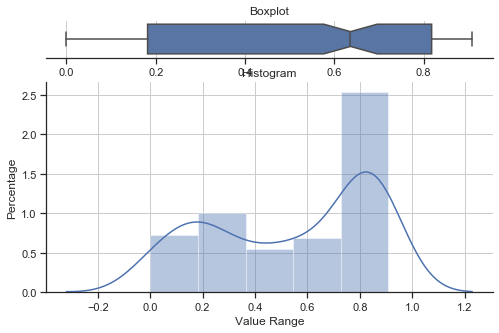

Target_Res_flg: False


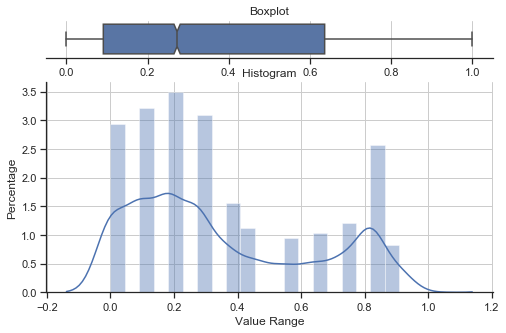


###########################################################

predictor: Letzte_Buchung_Delta
Target_Res_flg: True


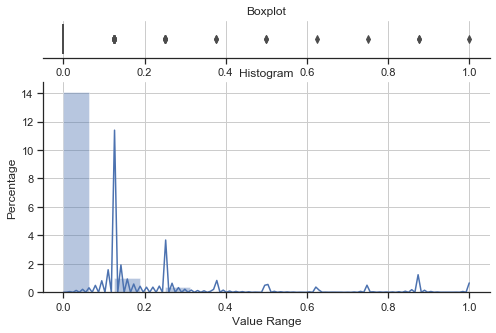

Target_Res_flg: False


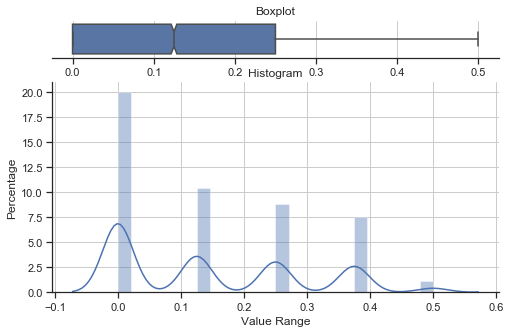


###########################################################

predictor: Erste_Letzte_Buchung_Delta
Target_Res_flg: True


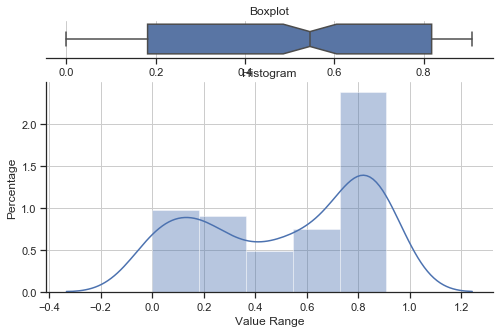

Target_Res_flg: False


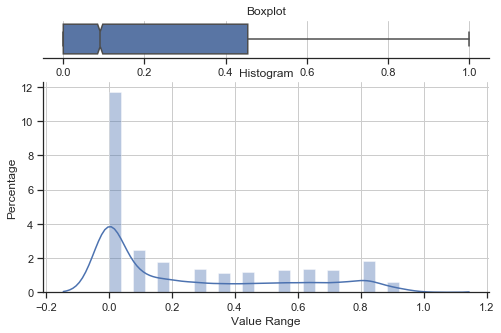


###########################################################



In [20]:
temp_df = training_all
for predictor in feature_colnames_dates:
    print(f"predictor: {predictor}")
    
    for boolean in [True, False]:
        print(f"Target_Res_flg: {boolean}")
        
        boxplot_histogram(
            temp_df.loc[temp_df.Target_Res_flg == boolean , # row filter
                        predictor ],           # column
            figsize=(8,5)
            )
    print("\n###########################################################\n")

del temp_df

## CRM Data

In [21]:
from vkprog_crm_prep  import crm_train_scoring

16:26:28 [INFO] [ipykernel_launcher.py] requests 'crm_prepare.py'
16:26:28 [INFO] [ipykernel_launcher.py]: Not running job 'crm_prepare.py': result is current ('Today') from 2019-11-19 09:43:22.250847.


In [22]:
(crm_train_df,
 crm_score_df,
 feature_colnames_crm
) = crm_train_scoring(
    day        = 2,
    month      = 12,
    year_score = 2019,
    year_train = 2018,
    year_span  = 4
    )

16:26:33 [INFO] Start.
16:26:33 [INFO] Started loading binary file
16:26:33 [INFO] Reading from file C:\Users\stc\data\vkprog\crm_data_vkprog.feather
16:26:33 [INFO] Finished loading binary file in 0.22s (0.38s CPU)
16:26:45 [INFO] Finished.


In [23]:
from pa_lib.data import desc_col

In [24]:
def scaling_crm_add2master(master_df,crm_df,feature_colnames_crm):
    
    container_df = pd.merge(master_df, crm_df,how="left", on="Endkunde_NR")

    for col_name in list(
        np.compress(
            ['RY'== x[0:2] for x in feature_colnames_crm],
            feature_colnames_crm
            )
        ):
        
        container_df.loc[:,col_name] = container_df.loc[:,col_name].fillna(0)
        
        max_ = np.nanmax(
            container_df.loc[:,col_name]
            )
        
        min_ = np.nanmin(
            container_df.loc[:,col_name]
            )
        
        if min_ == max_:
            container_df.loc[:,col_name] = 0
        
        else:
            container_df.loc[:,col_name] = (
                (container_df.loc[:,col_name] - min_) / (max_ - min_)
                )

    for col_name in list(
        np.compress(
            ['Letzter'== x[0:7] for x in feature_colnames_crm],
            feature_colnames_crm
            )
        ):
        
        max_ = np.nanmax(container_df.loc[:,col_name]) 
        # -> those who have never been contacted
        #    will be put together with the max-ones.
        
        container_df.loc[:,col_name] = (
            container_df.loc[:,col_name]
                        .fillna(max_)
            ) # No more NaNs!
        
        min_ = np.nanmin(container_df.loc[:,col_name])
        
        if max_ == min_:
            container_df.loc[:,col_name] = 1
            
        else:
            container_df.loc[:,col_name] = container_df.loc[:,col_name]/max_
            # scaling, doesn't need 0
    
    return container_df

In [25]:
training_all = scaling_crm_add2master(
    master_df            = training_all,
    crm_df               = crm_train_df,
    feature_colnames_crm = feature_colnames_crm
    )

In [26]:
scoring_all  = scaling_crm_add2master(
    master_df            = scoring_all,
    crm_df               = crm_score_df,
    feature_colnames_crm = feature_colnames_crm
    )

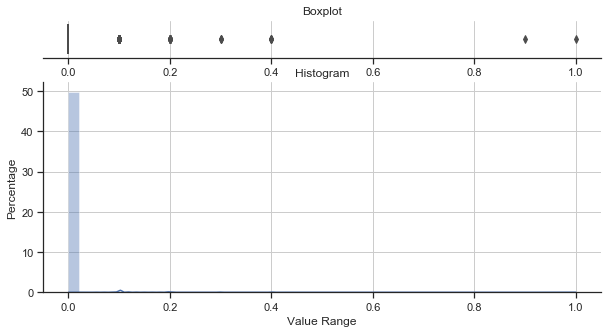

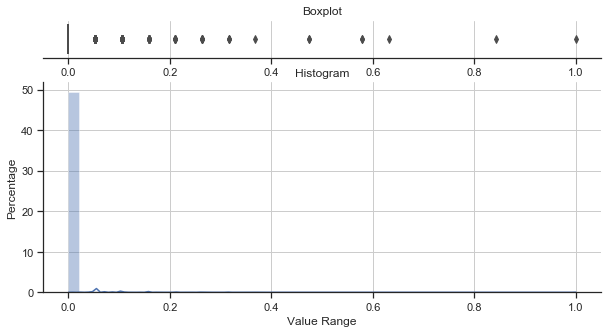

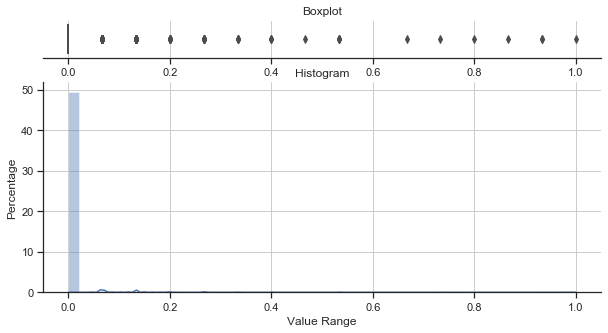

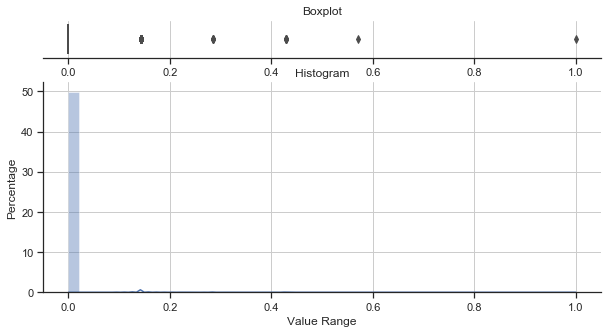

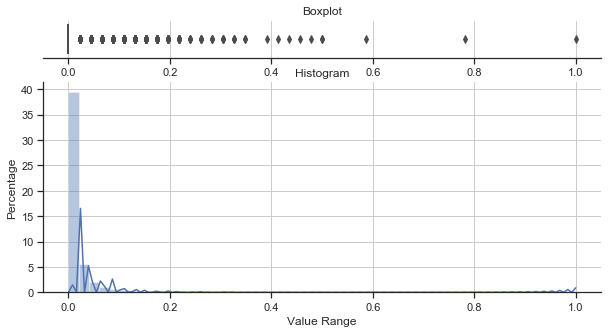

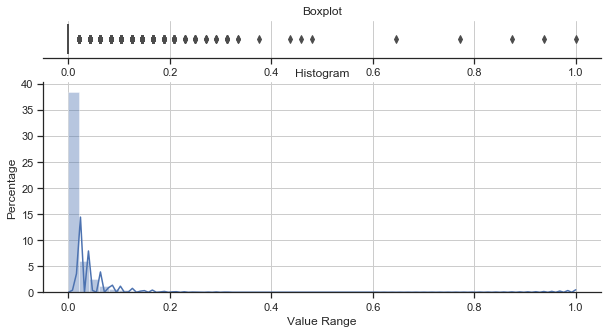

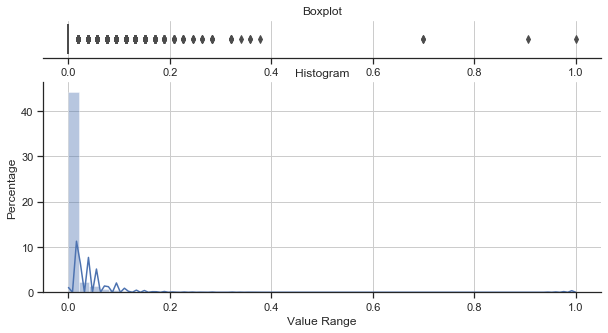

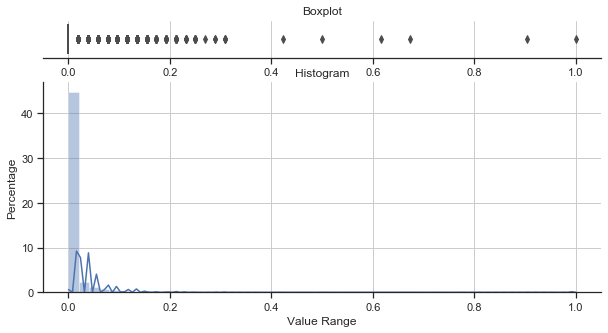

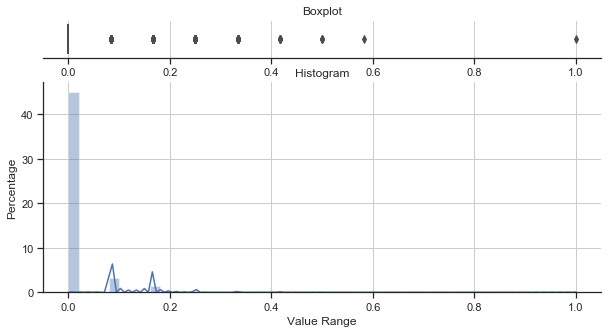

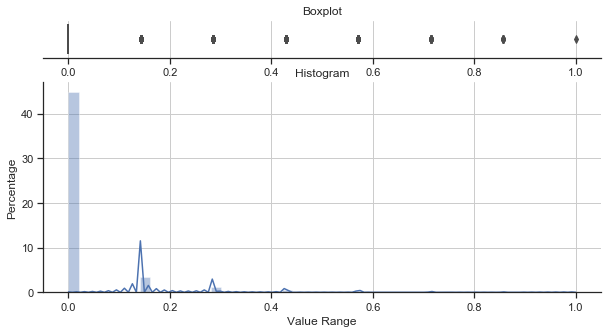

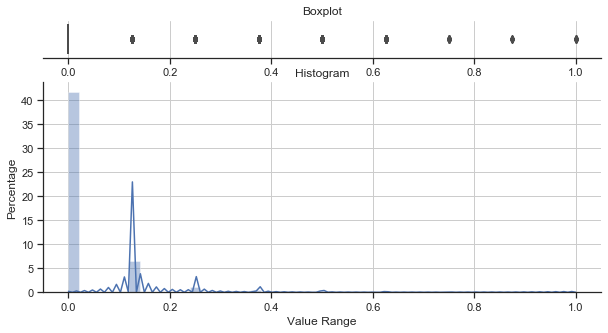

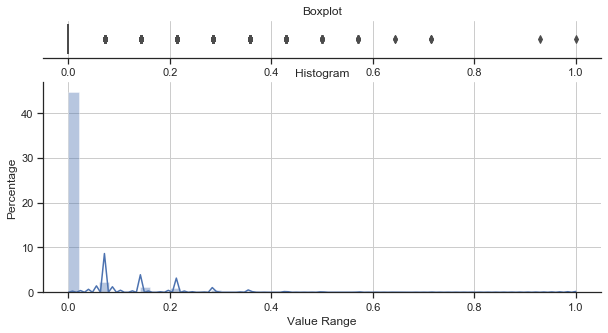

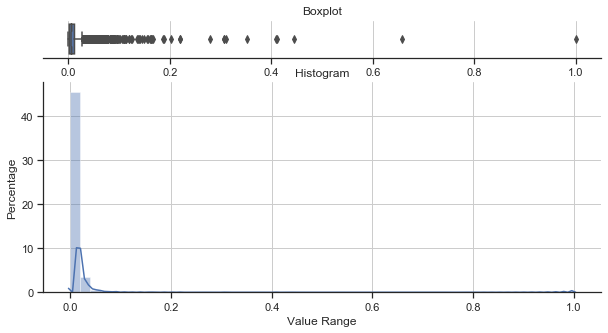

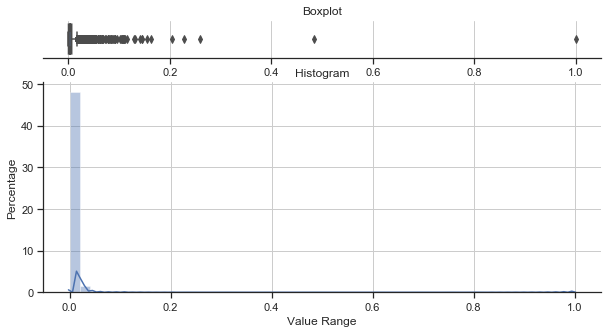

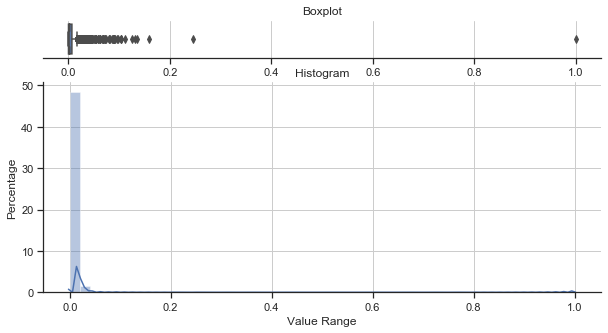

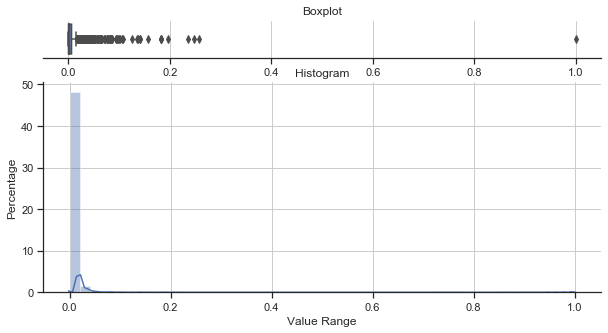

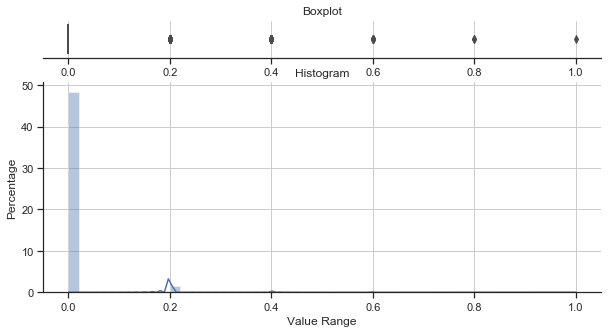

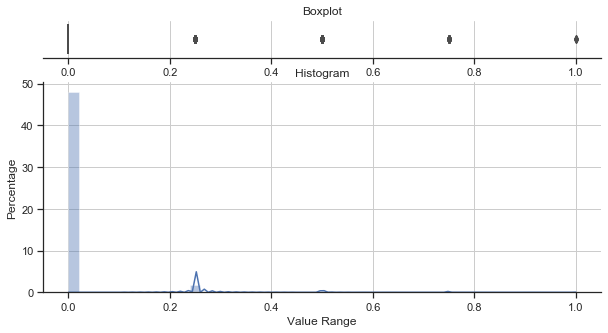

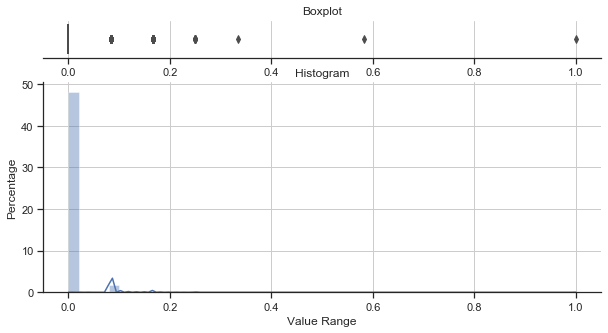

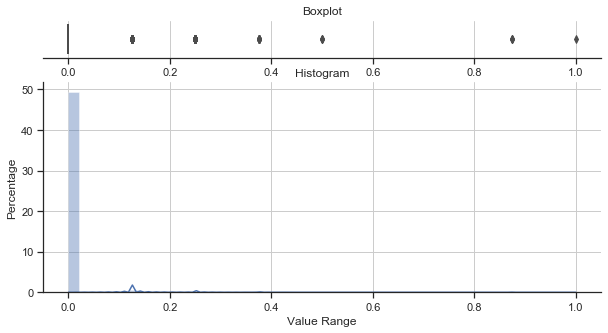

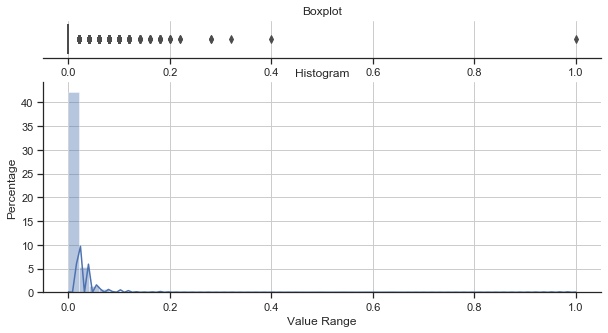

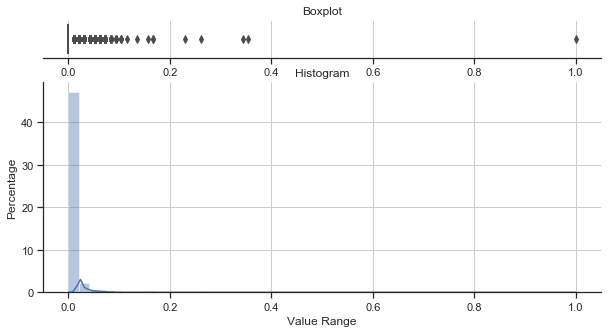

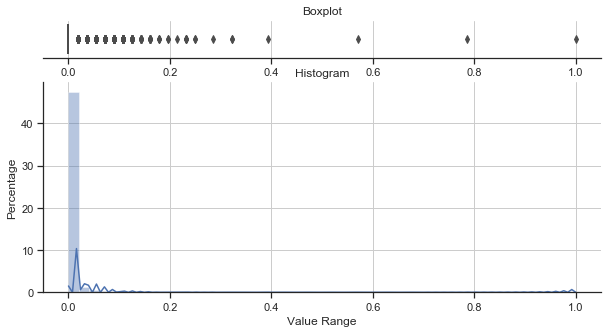

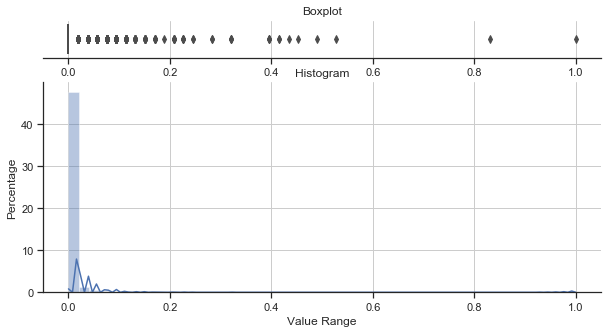

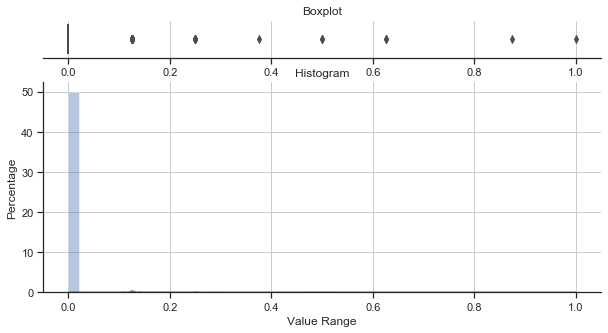

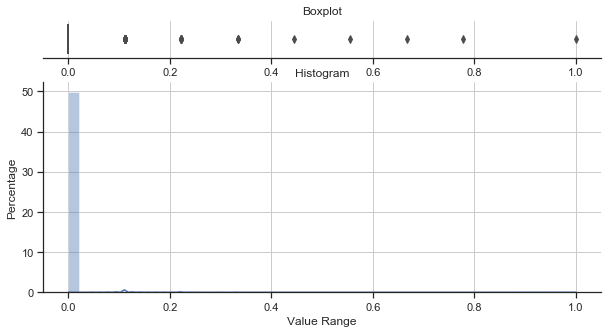

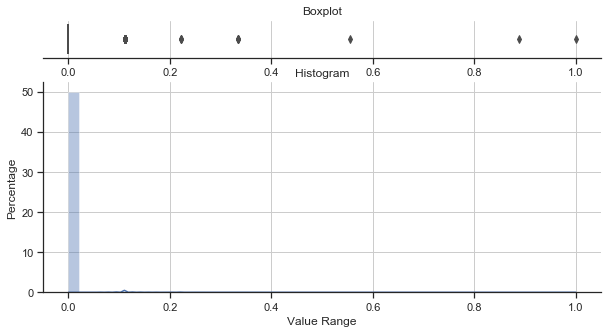

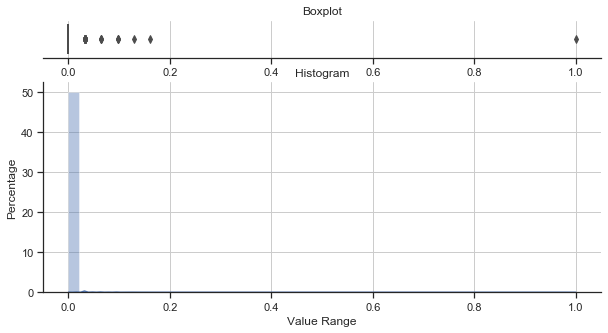

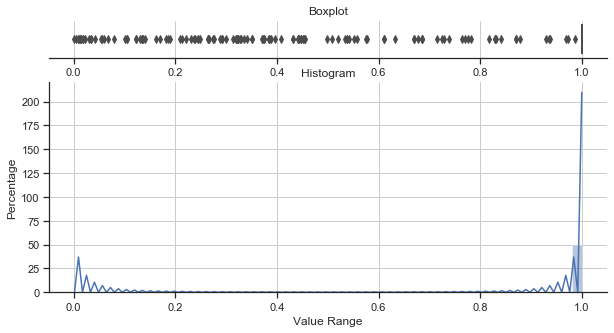

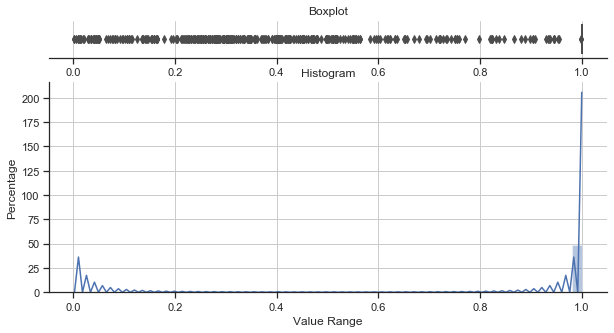

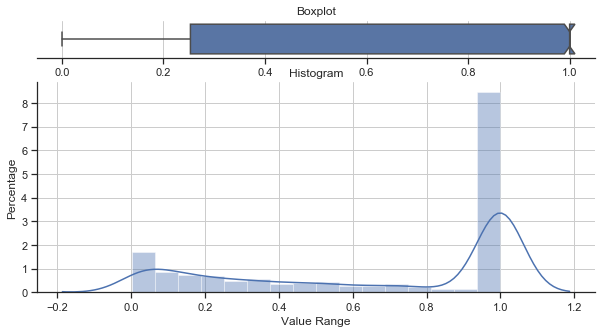

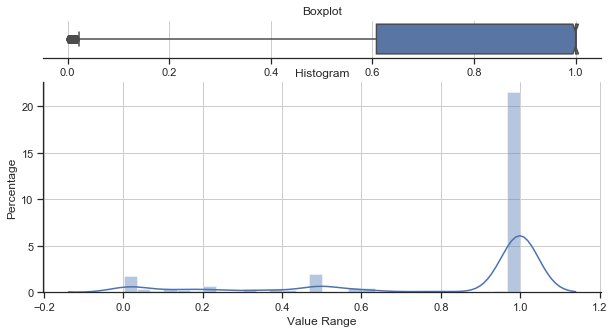

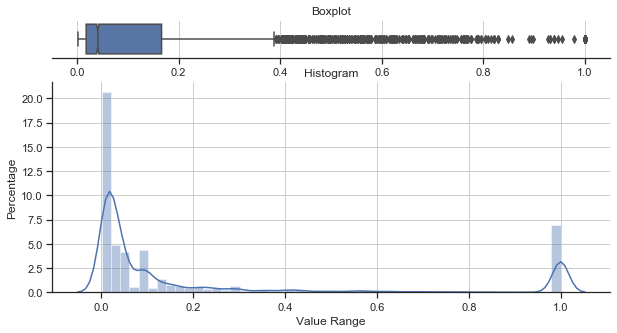

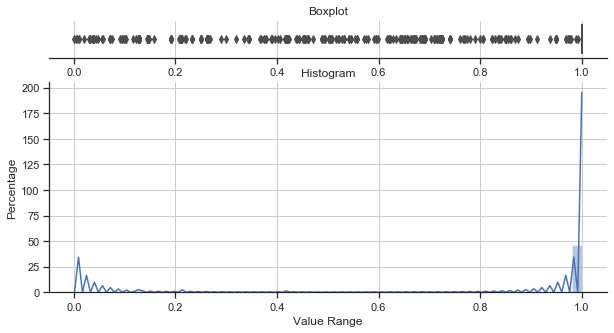

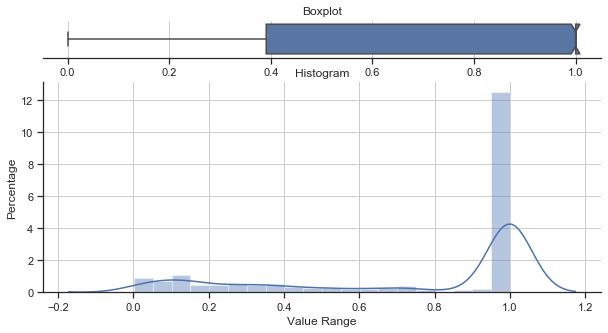

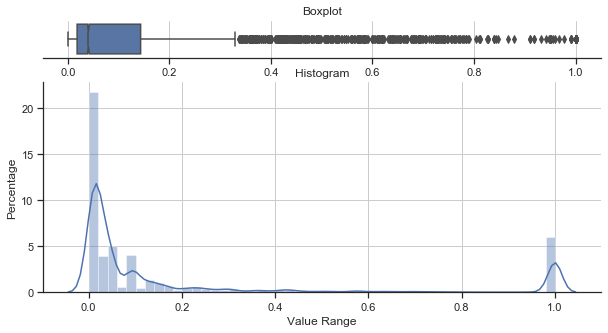

In [27]:
for x in feature_colnames_crm:
    boxplot_histogram(
        training_all.loc[:,x],
        figsize=(10,5)
        )

In [28]:
print(training_all.shape)
print(scoring_all.shape)

(12619, 345)
(12697, 345)


# Modeling

## Define Columns: Features versus Targets

In [29]:
from itertools import compress

features = (
    feature_colnames_bd         # Booking data
    + feature_colnames_dates    # Dates related to bookings
    + feature_colnames_branchen # Branches
    + feature_colnames_crm      # CRM (customer-vkber interactions)
    )


feature_columns_boolean = pd.Series(features).str.match('^Target')
feature_columns = pd.Series(features).loc[~feature_columns_boolean]

feature_columns_boolean = pd.Series(training_all.columns).str.match('^Target')
target_columns = pd.Series(training_all.columns).loc[feature_columns_boolean]

del feature_columns_boolean

In [30]:
print(f"Number of features:\n{len(feature_columns)}\n")
print(f"Target columns:\n{target_columns}")

Number of features:
338

Target columns:
214               Target_Aus_flg
215               Target_Res_flg
216    Target_Sum_Aus_RY_0_KW_49
217    Target_Sum_Res_RY_0_KW_49
dtype: object


## Split ``training_all`` into training-set (``X_train``,``y_train``) and test-set (``X_test``,``y_test``)

In [31]:
df_features = (
    training_all
    .loc[:,feature_columns]
    .to_numpy()
    )

df_target   = (
    training_all
    .loc[:, "Target_Res_flg"]
    .to_numpy()
    )

df_scoring_features = (
    scoring_all
    .loc[:,feature_columns]
    .to_numpy()
    )

In [32]:
print(f"df_features.shape: {df_features.shape}")
print(f"df_target.shape:   {df_target.shape}")

df_features.shape: (12619, 338)
df_target.shape:   (12619,)


In [33]:
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    df_features,
    df_target,
    train_size=0.75,
    random_state=42
    )

In [34]:
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape.:", X_test.shape)
print("y_test.shape:",  y_test.shape)
print("\ndf_scoring_features.shape:", df_scoring_features.shape)

X_train.shape: (9464, 338)
y_train.shape: (9464,)
X_test.shape.: (3155, 338)
y_test.shape: (3155,)

df_scoring_features.shape: (12697, 338)


In [35]:
from scipy import stats
print('y_train:')
print(pd.DataFrame(y_train).groupby(0)[0].count())
print(stats.describe(y_train))

print('\ny_test:')
print(pd.DataFrame(y_test).groupby(0)[0].count())
print(list(stats.describe(y_test)))


y_train:
0
False    9259
True      205
Name: 0, dtype: int64
DescribeResult(nobs=9464, minmax=(False, True), mean=0.02166103127641589, variance=0.021194070441544408, skewness=6.5717573204184845, kurtosis=41.18799427847396)

y_test:
0
False    3080
True       75
Name: 0, dtype: int64
[3155, (False, True), 0.02377179080824089, 0.023214050630748877, 6.252280969055796, 37.0910173160173]


## Balance Training Dataset

In [36]:
from imblearn.over_sampling import SMOTE
#ros = RandomOverSampler(random_state=42)
sm  = SMOTE(random_state=42)

(X_train_balanced, y_train_balanced) = sm.fit_resample(X_train, y_train)

In [37]:
print('y_train_balanced:')
print(pd.DataFrame(y_train_balanced).groupby(0)[0].count())
print(stats.describe(y_train_balanced))

y_train_balanced:
0
False    9259
True     9259
Name: 0, dtype: int64
DescribeResult(nobs=18518, minmax=(False, True), mean=0.5, variance=0.2500135011070908, skewness=0.0, kurtosis=-2.0)


## Intermezzo: RFECV

- https://towardsdatascience.com/feature-selection-in-python-recursive-feature-elimination-19f1c39b8d15
- https://scikit-learn.org/stable/modules/model_evaluation.html

In [59]:
correlated_features = set()
correlation_matrix = training_all
    .loc[:,feature_columns].corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [60]:
correlated_features

{'Erste_Letzte_Buchung_Delta',
 'Letzter_Kontakt_Delta_global',
 'Netto_Sum_Res_RY_0',
 'Netto_Sum_Res_RY_1',
 'Netto_Sum_Res_RY_2',
 'Netto_Sum_Res_RY_3',
 'RY_1_Anz_E-Mail',
 'RY_2_Anz_E-Mail',
 'RY_3_Anz_E-Mail'}

In [50]:
from sklearn.ensemble import (RandomForestClassifier)
from sklearn.feature_selection import (RFECV)
from sklearn.model_selection import (StratifiedKFold)

In [90]:
rfc = RandomForestClassifier(random_state=101,)
rfecv = RFECV(estimator=rfc,
              step=1,
              cv=StratifiedKFold(10),
              scoring="f1"
             )

In [ ]:
%%time
#Wall time: 12min 55s
import warnings
warnings.filterwarnings("ignore")
rfecv.fit(df_features, df_target)

In [76]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 209


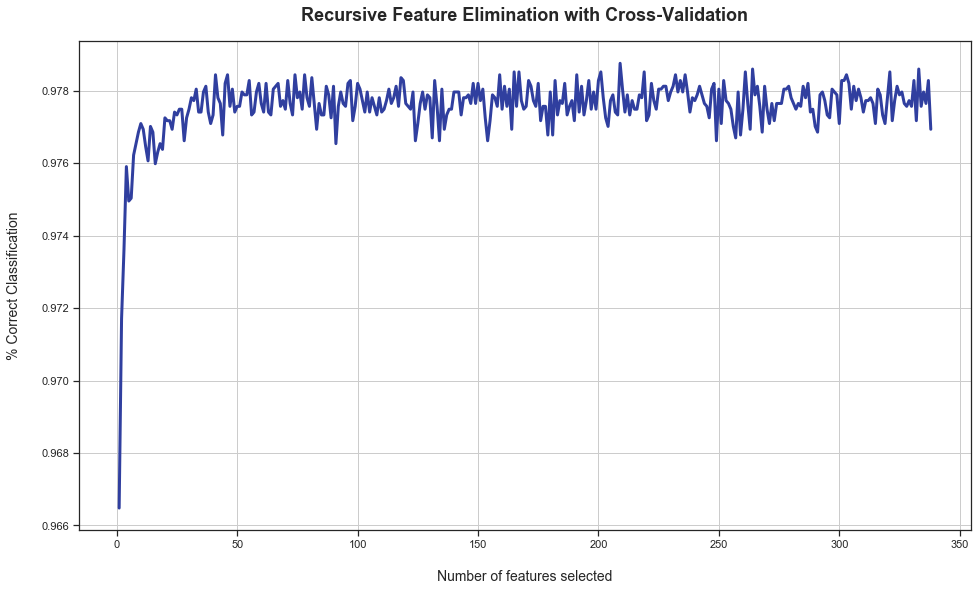

Wall time: 148 ms


In [77]:
%%time

plt.figure(figsize=(16, 9))
plt.grid()

plt.title('Recursive Feature Elimination with Cross-Validation',
          fontsize=18,
          fontweight='bold',
          pad=20)

plt.xlabel('Number of features selected',
           fontsize=14,
           labelpad=20)

plt.ylabel('% Correct Classification',
           fontsize=14,
           labelpad=20)

plt.plot(range(1, len(rfecv.grid_scores_) + 1),
         rfecv.grid_scores_,
         color='#303F9F',
         linewidth=3)

plt.show()

## Feature selection: SelectkBest

``SelectPercentile`` removes all but a user-specified highest scoring percentage of features.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html

In [31]:
from sklearn.feature_selection import (
    SelectKBest,
    f_classif,
    mutual_info_classif,
    #SelectPercentile
    )

from itertools import compress

In [32]:
%%time
#Wall time: 54 s

select = SelectKBest(
    score_func = mutual_info_classif,
    k          = 150 # How many features? (currently 219 is max)
    )

select.fit(
    X_train_balanced,
    y_train_balanced
    )

mask = select.get_support() # boolean array.

Wall time: 37.5 s


In [33]:
print(f"X_train_balanced.shape: {X_train_balanced.shape}")
print(f"X_train_balanced[:,mask].shape: {X_train_balanced[:,mask].shape}")

X_train_balanced.shape: (18438, 338)
X_train_balanced[:,mask].shape: (18438, 150)


In [34]:
# Reassign variable names due to lazyness
feature_columns  = feature_columns.loc[mask]
X_train_balanced = X_train_balanced[:,mask]
X_train          = X_train[:,mask]
X_test           = X_test[:,mask]
X_scoring        = df_scoring_features[:,mask]

In [35]:
print("X_scoring.shape:",X_scoring.shape)

X_scoring.shape: (12786, 150)


## Model Training

### Logistic Regression (base model)

In [36]:
from sklearn.linear_model import LogisticRegression

In [37]:
%%time
# Wall time: 1min 13s
logreg_C1000 = LogisticRegression(
    n_jobs   = -1,
    solver   = "sag",
    max_iter = 100000,
    C        = 1000 #adjustable, bigger mean less restriction on coefficients
    ).fit(
        X_train_balanced,
        y_train_balanced
        ) # bigger C

print(f"Training set score: {logreg_C1000.score(X_train_balanced, y_train_balanced)}")
print(f"Test set score: {logreg_C1000.score(X_test, y_test)}")

Training set score: 0.8182015402972123
Test set score: 0.8060221870047544
Wall time: 53.4 s


In [38]:
%%time
# Wall time: 543 ms
logreg_C0001 = LogisticRegression(
    n_jobs=-1,
    solver="sag",
    max_iter=100000,
    C=0.001 #adjustable, bigger mean less restriction on coefficients
    ).fit(
        X_train_balanced,
        y_train_balanced
        ) # bigger C

print(f"Training set score: {logreg_C0001.score(X_train_balanced,y_train_balanced)}")
print(f"Test set score:     {logreg_C0001.score(X_test, y_test)}")

Training set score: 0.6969844885562425
Test set score:     0.7746434231378764
Wall time: 329 ms


#### Plot Coefficients

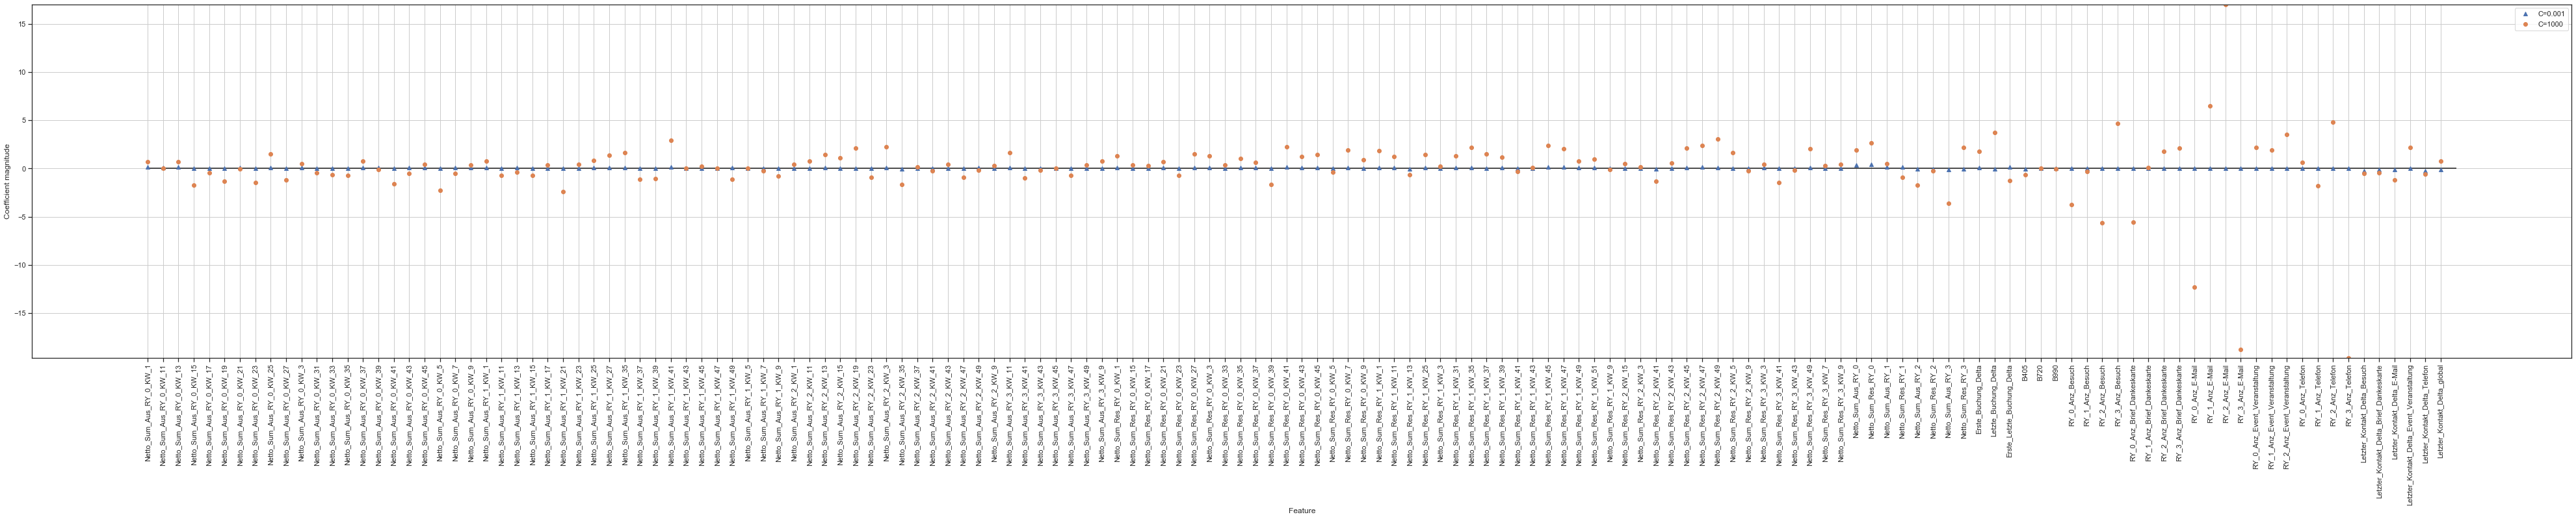

In [39]:
# %% Plot: Compare LogReg-coefficients for different C (1000, 0.001)
plt.figure(figsize=(70,10))

plt.grid()

plt.plot(logreg_C0001.coef_.T,
         '^',
         label="C=0.001"
        )

plt.plot(logreg_C1000.coef_.T,
         'o',
         label="C=1000"
        )

plt.xticks(range(len(feature_columns)),
           feature_columns,
           rotation=90
          )

plt.hlines(0, 0, len(feature_columns))

plt.ylim(min(logreg_C1000.coef_.T),
         max(logreg_C1000.coef_.T)
        )

plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()
plt.savefig('LogReg_Coefficient_Importance.png')

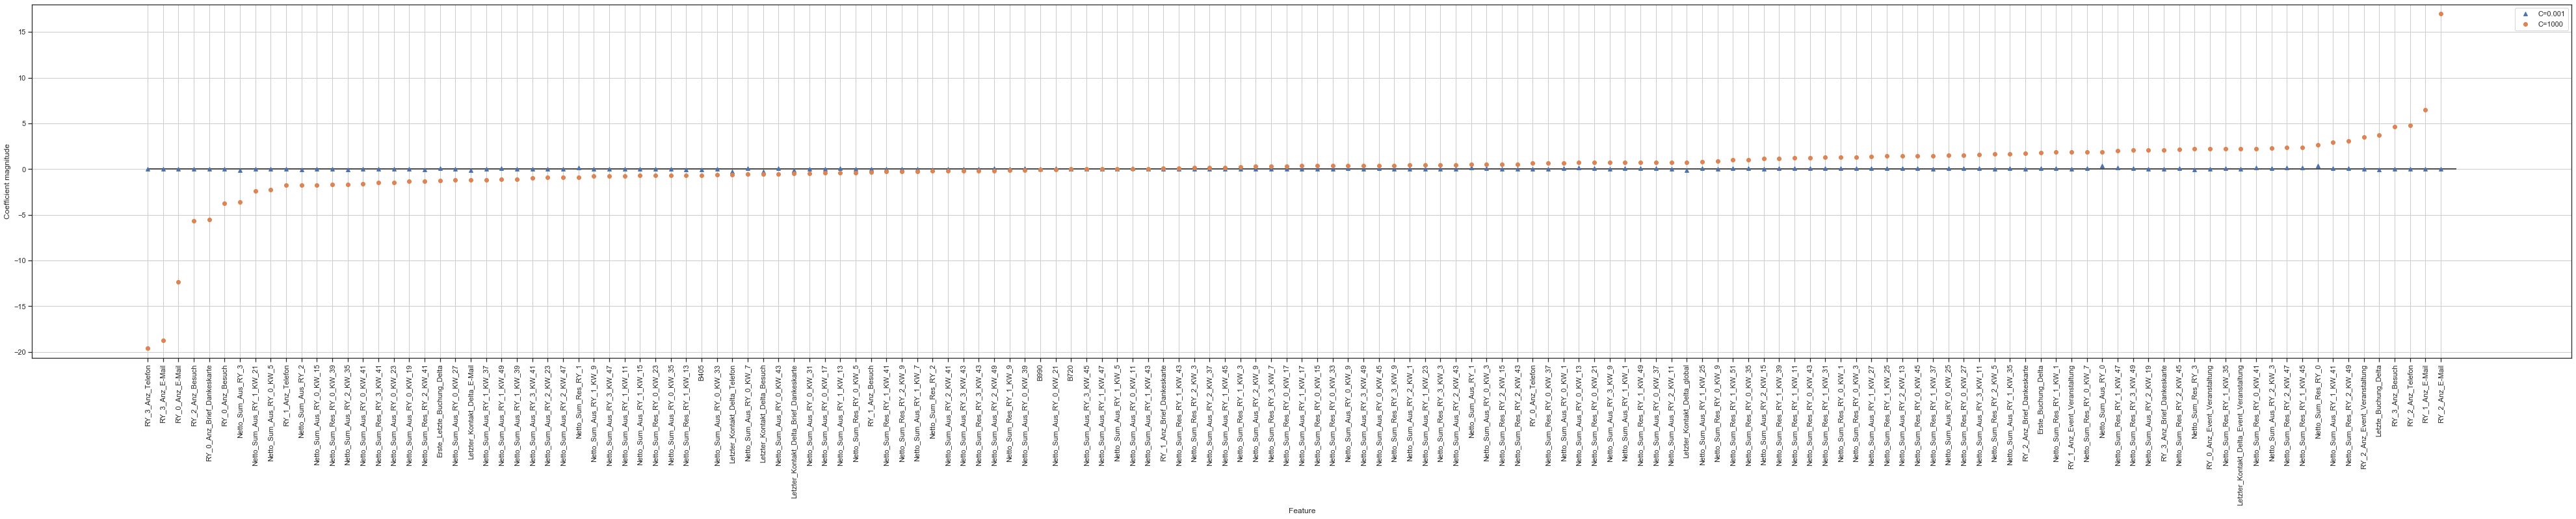

In [40]:
test_df = (
    pd.DataFrame(
        data={'feature': pd.Series(feature_columns), 
              'C1000':   list(logreg_C1000.coef_.T),
              'C0001':   list(logreg_C0001.coef_.T)}
    )
    .sort_values(by=['C1000'])
    .reset_index()
    )
    
# %% Plot: Compare LogReg-coefficients for different C (1000, 0.001)
plt.figure(figsize=(70,10))
plt.grid()

plt.plot(
    test_df.loc[:,'C0001'],
    '^', 
    label="C=0.001"
    )

plt.plot(
    test_df.loc[:,'C1000'],
    'o',
    label="C=1000"
    )


plt.xticks(
    range(len(feature_columns)),
    test_df.loc[:,'feature'],
    rotation=90
    )

plt.hlines(0, 0, len(feature_columns))

plt.ylim(
    min(logreg_C1000.coef_.T)-1,
    max(logreg_C1000.coef_.T)+1
    )

plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()
plt.savefig('this_is_a_test.png')

del test_df

### Model Training: Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
%%time 
# Wall time: 13min
forest_01 = RandomForestClassifier(
    n_estimators = 5*10**3,
    max_depth    = 10,
    criterion    = 'gini',  #criterion='gini',
    random_state = 42,
    n_jobs       = -1
    )

forest_01.fit(
    X_train_balanced,
    y_train_balanced
    )

Wall time: 17.3 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5000,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [43]:
%%time
# %% Validate Accuracy
print(f"Accuracy on balanced training set:   {forest_01.score(X_train_balanced, y_train_balanced)}")
print(f"Accuracy on unbalanced training set: {forest_01.score(X_train,          y_train)}")
print(f"Accuracy on test set (validation):   {forest_01.score(X_test,           y_test)}")

Accuracy on balanced training set:   0.9925154572079401
Accuracy on unbalanced training set: 0.9916534601162177
Accuracy on test set (validation):   0.967987321711569
Wall time: 5.17 s


In [44]:
# %% Plot: Feature importance
def plot_feature_importances(
        model,
        feature_columns,
        figsize=(20,100)
        ):
    
    from operator import itemgetter
    
    dict_feature_importance = sorted(
        dict(
            zip(feature_columns,model.feature_importances_)
        ).items(),
        key=itemgetter(1)
        )
    
    n_features = len(feature_columns)
    
    plt.figure(figsize=figsize)
    plt.grid()
    
    plt.barh(
        np.arange(n_features),
        [y for (x,y) in dict_feature_importance],
        align='center'
        )
    
    plt.yticks(
        np.arange(n_features),
        [x for (x,y) in dict_feature_importance]
        )
    
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    plt.show()

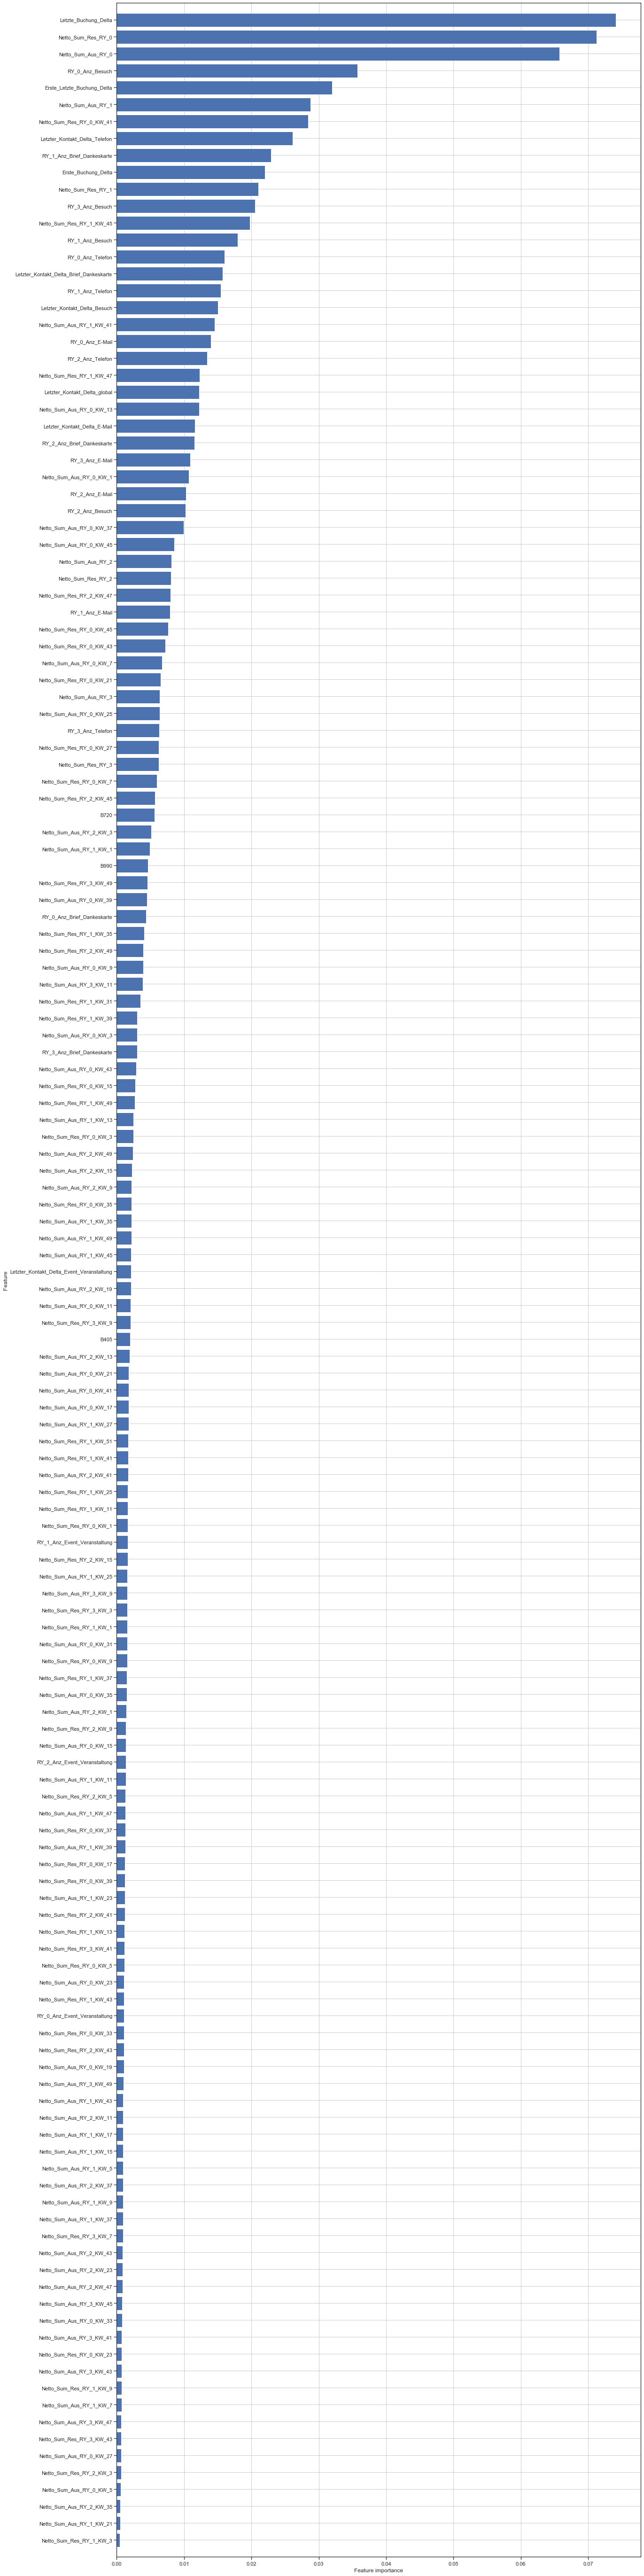

In [45]:
plot_feature_importances(forest_01,feature_columns)

# Model Validation

## Confusion Matrix

In [46]:
from sklearn.metrics import confusion_matrix

In [47]:
%%time

def confusion_matrices(X_test,y_test):
    global pred_forest_01, pred_logreg_C0001, pred_logreg_C1000
    
    pred_forest_01    = forest_01.predict(X_test)
    pred_logreg_C0001 = logreg_C0001.predict(X_test)
    pred_logreg_C1000 = logreg_C1000.predict(X_test)


    # Wall time: 20.9ms

    confusion_logreg_C0001 = (
        confusion_matrix(
            y_test,
            pred_logreg_C0001
            )
        )
    
    df_confusion_logreg_C0001 = (
        pd.DataFrame(
            confusion_logreg_C0001,
            index   = ["Fact 0", "Fact 1"],
            columns = ["Pred 0", "Pred 1"]
            )
        )
    
    confusion_logreg_C1000 = (
        confusion_matrix(
            y_test,
            pred_logreg_C1000
            )
        )
    
    df_confusion_logreg_C1000 = (
        pd.DataFrame(
            confusion_logreg_C1000,
            index   = ["Fact 0", "Fact 1"],
            columns = ["Pred 0", "Pred 1"]
            )
        )

    confusion_forest_01 = (
        confusion_matrix(
            y_test,
            pred_forest_01
            )
        )
    
    df_confusion_forest_01 = (
        pd.DataFrame(
            confusion_forest_01,
            index=["Fact 0", "Fact 1"],
            columns=["Pred 0","Pred 1"]
            )
        )

    print("Test set balance:")
    print(pd.Series(y_test).value_counts())

    print("\nConfusion Matrices:")

    print("\nRandom Forest (forest_01):")
    display(df_confusion_forest_01)

    print("\nLogistic Regression C=0.001:")
    display(df_confusion_logreg_C0001)

    print("\nLogistic Regression C=1000:")
    display(df_confusion_logreg_C1000)

Wall time: 0 ns


In [48]:
confusion_matrices(
    X_test = X_train_balanced,
    y_test = y_train_balanced
    )

Test set balance:
True     9219
False    9219
dtype: int64

Confusion Matrices:

Random Forest (forest_01):


,Pred 0,Pred 1
Fact 0,9199,20
Fact 1,118,9101



Logistic Regression C=0.001:


,Pred 0,Pred 1
Fact 0,7151,2068
Fact 1,3519,5700



Logistic Regression C=1000:


,Pred 0,Pred 1
Fact 0,7538,1681
Fact 1,1671,7548


In [49]:
confusion_matrices(
    X_test = X_train,
    y_test = y_train
    )

Test set balance:
False    9219
True      246
dtype: int64

Confusion Matrices:

Random Forest (forest_01):


,Pred 0,Pred 1
Fact 0,9199,20
Fact 1,59,187



Logistic Regression C=0.001:


,Pred 0,Pred 1
Fact 0,7151,2068
Fact 1,70,176



Logistic Regression C=1000:


,Pred 0,Pred 1
Fact 0,7538,1681
Fact 1,51,195


In [50]:
confusion_matrices(
    X_test = X_test,
    y_test = y_test
    )

Test set balance:
False    3090
True       65
dtype: int64

Confusion Matrices:

Random Forest (forest_01):


,Pred 0,Pred 1
Fact 0,3041,49
Fact 1,52,13



Logistic Regression C=0.001:


,Pred 0,Pred 1
Fact 0,2397,693
Fact 1,18,47



Logistic Regression C=1000:


,Pred 0,Pred 1
Fact 0,2506,584
Fact 1,28,37


1. $Precision =\frac{TP}{TP+FP}$
2. $Recall =\frac{TP}{TP+FN}$ <-- Optimising target!
3. $f_{1} = 2 \cdot \frac{precision \cdot recall}{precision + recall} = \frac{2 \cdot TP}{2 \cdot TP + (FN + FP)}$
4. $Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$ KPI combines Precision and Recall


## Classification Report

In [51]:
from sklearn.metrics import classification_report

In [52]:
%%time
## Wall time: 9.94ms

print("\n")
print("Logistic Regression C=0.001:")
print(
    classification_report(
        y_test,
        pred_logreg_C0001,
        target_names=["not booking = 0", "booking = 1"]
        )
    )

print("Logistic Regression C=1000:")
print(
    classification_report(
        y_test,
        pred_logreg_C1000,
        target_names=["not booking = 0", "booking = 1"]
        )
    )

print("Random Forest:")
print(
    classification_report(
        y_test,
        pred_forest_01,
        target_names=["not booking = 0", "booking = 1"]
        )
    )



Logistic Regression C=0.001:
                 precision    recall  f1-score   support

not booking = 0       0.99      0.78      0.87      3090
    booking = 1       0.06      0.72      0.12        65

       accuracy                           0.77      3155
      macro avg       0.53      0.75      0.49      3155
   weighted avg       0.97      0.77      0.86      3155

Logistic Regression C=1000:
                 precision    recall  f1-score   support

not booking = 0       0.99      0.81      0.89      3090
    booking = 1       0.06      0.57      0.11        65

       accuracy                           0.81      3155
      macro avg       0.52      0.69      0.50      3155
   weighted avg       0.97      0.81      0.88      3155

Random Forest:
                 precision    recall  f1-score   support

not booking = 0       0.98      0.98      0.98      3090
    booking = 1       0.21      0.20      0.20        65

       accuracy                           0.97      3155
      

## Precision-Recall Curve

In [53]:
from sklearn.metrics import precision_recall_curve

def prec_rec_values(X_test,y_test):
    global precision_forest_01,    recall_forest_01,    thresholds_forest_01
    global precision_logreg_C0001, recall_logreg_C0001, thresholds_logreg_C0001
    global precision_logreg_C1000, recall_logreg_C1000, thresholds_logreg_C1000 
    
    
    # LogReg C=0.001
    (precision_logreg_C0001, recall_logreg_C0001, thresholds_logreg_C0001) = (
        precision_recall_curve(
            y_test, 
            logreg_C0001.predict_proba(X_test)[:,1]
            )
        )
    
    
    # LogReg C=1000
    (precision_logreg_C1000, recall_logreg_C1000, thresholds_logreg_C1000) = (
        precision_recall_curve(
            y_test, 
            logreg_C1000.predict_proba(X_test)[:,1]
            )
        )
    
    
    # RandomForestClassifier has predict_proba, but not decision_function
    (precision_forest_01, recall_forest_01, thresholds_forest_01) = (
        precision_recall_curve(
            y_test,
            forest_01.predict_proba(X_test)[:, 1]
            )
        )
    
    

In [54]:
%%time
# Wall time: 22.4s

def prec_rec_curve(X_train,y_train):
    prec_rec_values(X_train,y_train)

    plt.figure(figsize=(15,12))
    plt.grid()

    def optimum_point(precision_forest_01,
                      recall_forest_01,
                      thresholds_forest_01,
                      name,
                      dot):
        
        optimum_idx = (
            pd.Series.idxmin(
                np.power(1-pd.Series(precision_forest_01),2)
                + np.power(1-pd.Series(recall_forest_01),2)
                )
            )
        
        return plt.plot(precision_forest_01[optimum_idx],
                     recall_forest_01[optimum_idx],
                     dot,
                     markersize = 10,
                     label      = f"{name}: threshold {thresholds_forest_01[optimum_idx]}",
                     fillstyle  = "none",
                     c          = 'k',
                     mew        = 2
                     )

    
    ## Apply optium_point():
    
    # Optimum: Forest 
    optimum_point(precision_forest_01,
                  recall_forest_01,
                  thresholds_forest_01,
                  name="forest_01",
                  dot='o'
                 )
    
    # Optimum: LogReg C = 0.001
    optimum_point(precision_logreg_C0001,
                  recall_logreg_C0001,
                  thresholds_logreg_C0001,
                  name="logreg_C0001",
                  dot='x'
                 )
    
    # Optimum: LogReg C = 1000
    optimum_point(precision_logreg_C1000,
                  recall_logreg_C1000,
                  thresholds_logreg_C1000,
                  name="logreg_C1000",
                  dot='+'
                 )
    
    # Prec-Rec Curve: LogReg C = 0.001
    plt.plot(precision_logreg_C0001,
             recall_logreg_C0001,
             label="Logistic Regression, C=0.001"
            )
    
    # Prec-Rec Curve: LogReg C = 1000
    plt.plot(precision_logreg_C1000,
             recall_logreg_C1000,
             label="Logistic Regression, C=1000"
            )
    
    # Prec-Rec Curve: Forest
    plt.plot(precision_forest_01,
             recall_forest_01,
             label="Random Forest"
            )

    plt.xlabel("Precision")
    plt.ylabel("Recall")
    plt.legend(loc="best")

    plt.show()

Wall time: 0 ns


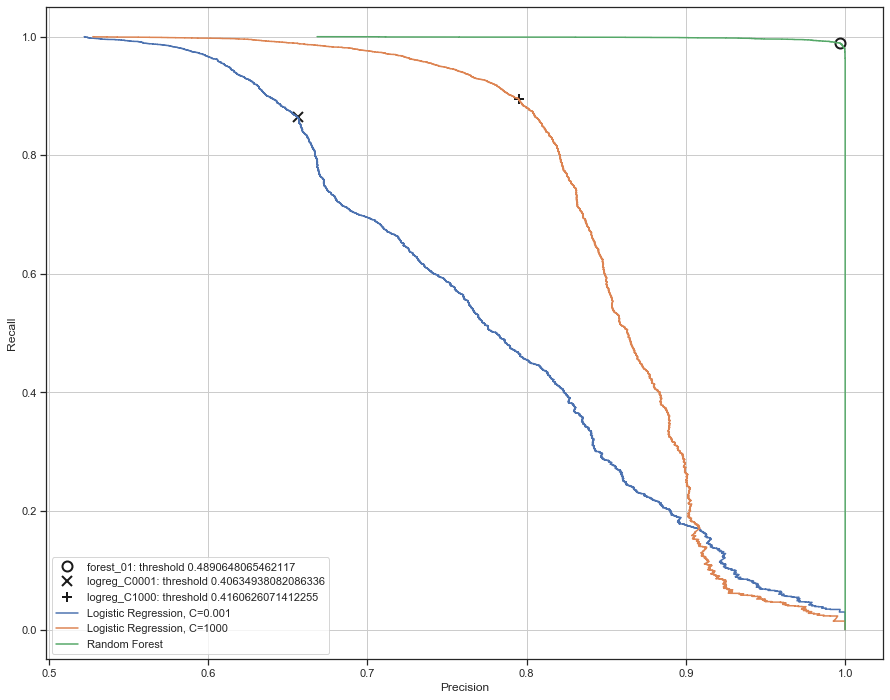

In [55]:
prec_rec_curve(
    X_train = X_train_balanced,
    y_train = y_train_balanced
    )

=> Should give very nice curves, because models have been trained on this data.

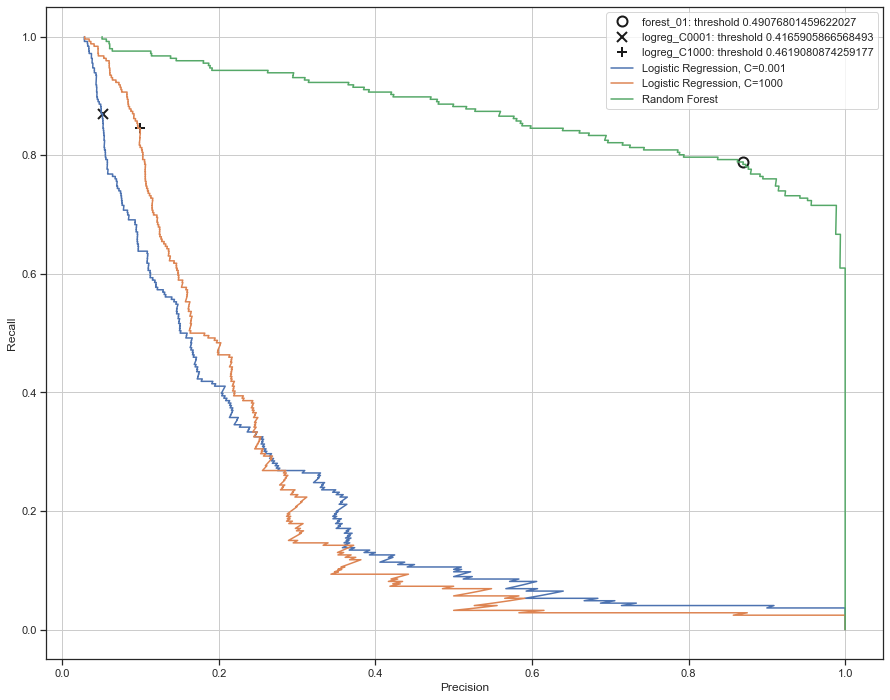

In [56]:
prec_rec_curve(
    X_train = X_train,
    y_train = y_train
    )

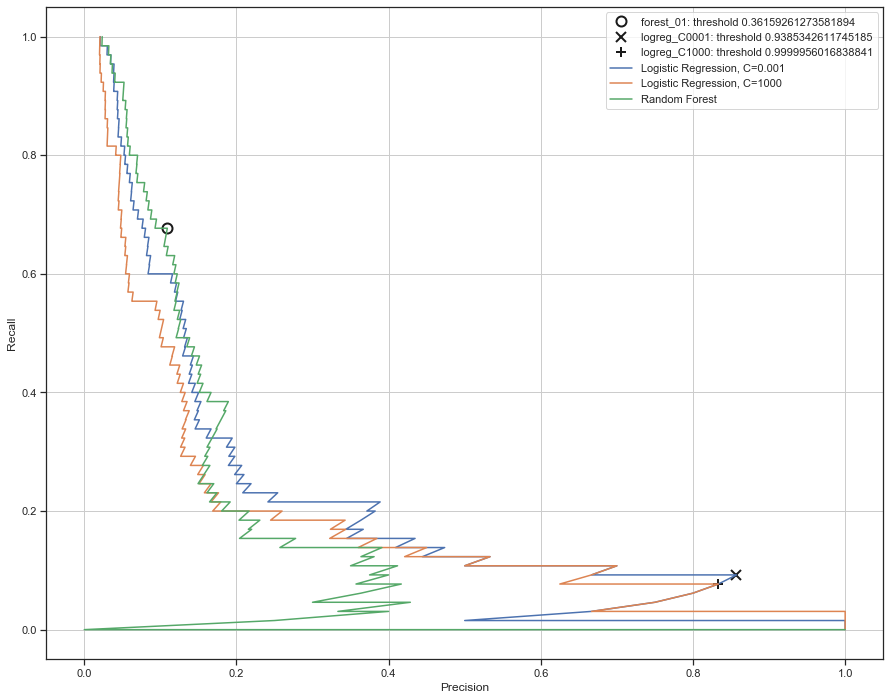

In [57]:
prec_rec_curve(
    X_train = X_test,
    y_train = y_test
    )

In [58]:
%%time
#Wall time: 19.7 s

# Area under the Recall/Precision-curves:
from sklearn.metrics import average_precision_score 

avg_precision_logreg_C0001 = (
    average_precision_score(
        y_test,
        logreg_C0001.predict_proba(X_test)[:, 1]
        )
    )

avg_precision_logreg_C1000 = (
    average_precision_score(
        y_test,
        logreg_C1000.predict_proba(X_test)[:, 1]
        )
    )

avg_precision_forest_01 = (
    average_precision_score(
        y_test,
        forest_01.predict_proba(X_test)[:, 1]
        )
    )


print(f"Average Precision of LogReg C=0.001: {avg_precision_logreg_C0001}")
print(f"Average Precision of LogReg C=1000:  {avg_precision_logreg_C1000}")
print(f"Average Precision of forest_01:      {avg_precision_forest_01}")

Average Precision of LogReg C=0.001: 0.2153054328452052
Average Precision of LogReg C=1000:  0.18902799185795577
Average Precision of forest_01:      0.15730111057020726
Wall time: 1.52 s


=> Winner: Forest

## Receiver Operating Characteristics (ROC) and AUC


In [59]:
%%time
from sklearn.metrics import roc_curve
def roc_curve_graph(X_test,y_test):
    global fpr_logreg_C0001, tpr_logreg_C0001, thresholds_logreg_C0001
    global fpr_logreg_C1000, tpr_logreg_C1000, thresholds_logreg_C1000
    global fpr_forest_01, tpr_forest_01, thresholds_forest_01
    
    (fpr_logreg_C0001, tpr_logreg_C0001, thresholds_logreg_C0001) = (
        roc_curve(
            y_test,
            logreg_C0001.predict_proba(X_test)[:, 1]
            )
        )
    
    
    (fpr_logreg_C1000, tpr_logreg_C1000, thresholds_logreg_C1000) = (
        roc_curve(
            y_test,
            logreg_C1000.predict_proba(X_test)[:, 1]
            )
        )
    
    (fpr_forest_01, tpr_forest_01, thresholds_forest_01) = (
        roc_curve(
            y_test,
            forest_01.predict_proba(X_test)[:, 1]
            )
        )

    def threshold_dot_50perc(fpr_forest_01,
                             tpr_forest_01,
                             thresholds_forest_01,
                             name,
                             dot):

        close_default_index_forest_01 = (
            pd.Series.idxmin(
                np.power(1-pd.Series(tpr_forest_01),2)
                +np.power(pd.Series(fpr_forest_01),2)
                )
            )
        
        return plt.plot(
            fpr_forest_01[close_default_index_forest_01],
            tpr_forest_01[close_default_index_forest_01],
            dot,
            markersize=10,
            label=f"{name} threshold: {thresholds_forest_01[close_default_index_forest_01]}",
            fillstyle="none",
            c='k',
            mew=2)


    plt.figure(figsize=(15,12))
    plt.grid()

    plt.plot(fpr_forest_01,
             fpr_forest_01,
             linestyle='dotted',
             label="base line"
            )

    plt.plot(fpr_logreg_C0001,
             tpr_logreg_C0001,
             label="logreg_C0001"
            )
    
    plt.plot(fpr_logreg_C1000,
             tpr_logreg_C1000,
             label="logreg_C1000"
            )
    
    plt.plot(fpr_forest_01,
             tpr_forest_01,
             label="forest_01"
            )


    plt.xlabel("False-Postive Rate (FPR)")
    plt.ylabel("True-Positive Rate (TPR) aka. Recall")

    # find threshold closest to zero
    threshold_dot_50perc(fpr_forest_01,
                         tpr_forest_01,
                         thresholds_forest_01,
                         'forest_01',
                         dot='^'
                        )
    
    threshold_dot_50perc(fpr_logreg_C0001,
                         tpr_logreg_C0001,
                         thresholds_logreg_C0001,
                         'logreg_C0001',
                         dot='x'
                        )
    
    threshold_dot_50perc(fpr_logreg_C1000,
                         tpr_logreg_C1000,
                         thresholds_logreg_C1000,
                         'logreg_C1000',
                         dot='+'
                        )

    plt.legend(loc=4)
    plt.show()

Wall time: 0 ns


In [60]:
%%time
# Wall time: 17.6s
from sklearn.metrics import roc_auc_score

def roc_auc(X_test,y_test):
    forest_01_auc = roc_auc_score(
        y_test,
        forest_01.predict_proba(X_test)[:, 1]
        )
    
    logreg_C0001_auc = roc_auc_score(
        y_test,
        logreg_C0001.predict_proba(X_test)[:, 1]
        )
    
    logreg_C1000_auc = roc_auc_score(
        y_test,
        logreg_C1000.predict_proba(X_test)[:, 1]
        )


    print("AUC for forest_01:    {:.3f}".format(forest_01_auc))
    print("AUC for logreg_C0001: {:.3f}".format(logreg_C0001_auc))
    print("AUC for logreg_C1000: {:.3f}".format(logreg_C1000_auc))

Wall time: 0 ns


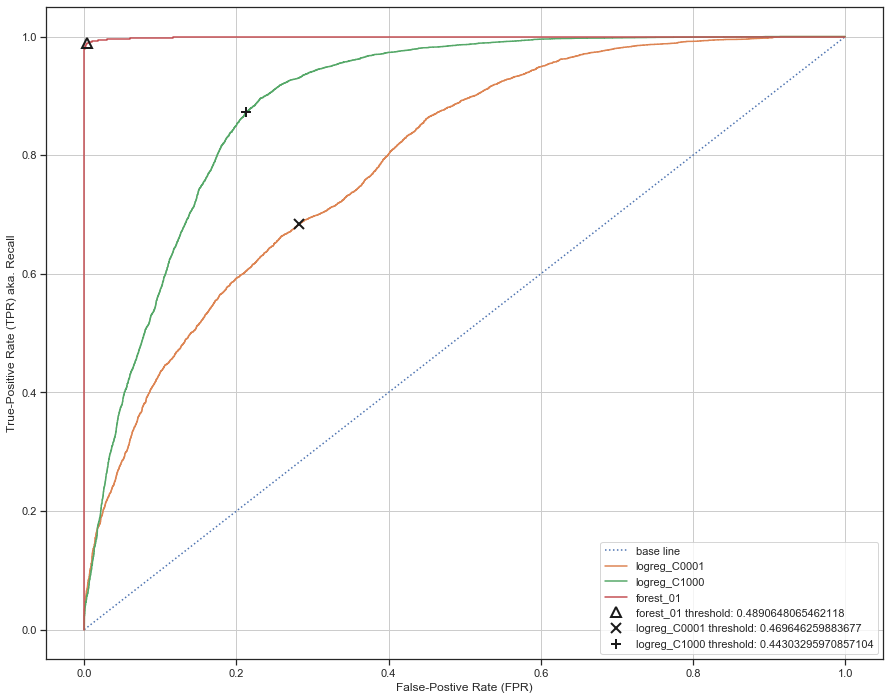

AUC for forest_01:    0.999
AUC for logreg_C0001: 0.791
AUC for logreg_C1000: 0.891
Wall time: 3.99 s


In [61]:
%%time
#Wall time: 10.6 s
roc_curve_graph(X_train_balanced,
                y_train_balanced
               )

roc_auc(X_train_balanced,
        y_train_balanced
       )

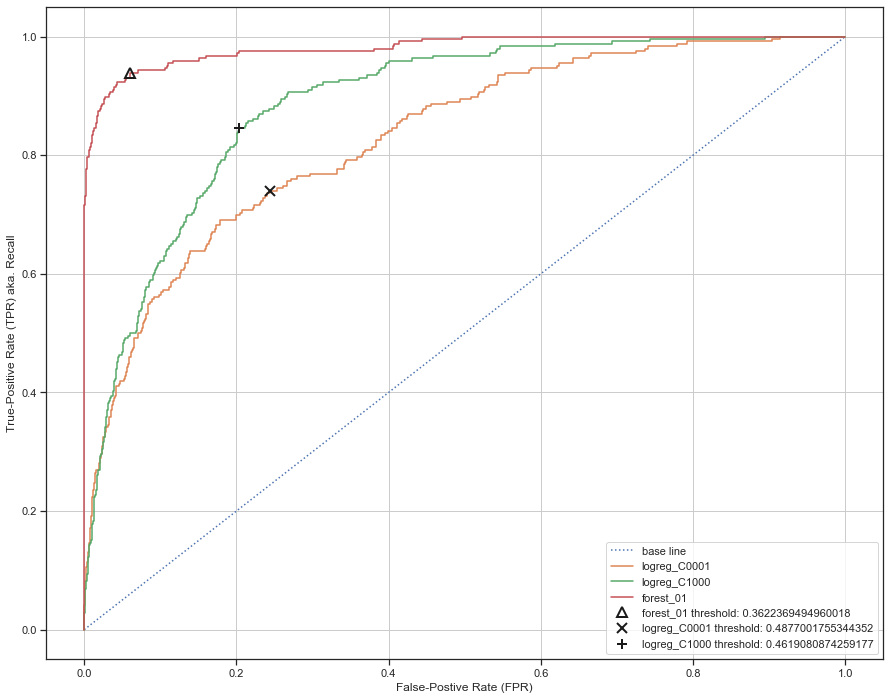

AUC for forest_01:    0.981
AUC for logreg_C0001: 0.830
AUC for logreg_C1000: 0.887
Wall time: 3.64 s


In [62]:
%%time
#Wall time: 10.6 s
roc_curve_graph(X_train,
                y_train
               )

roc_auc(X_train,
        y_train
       )

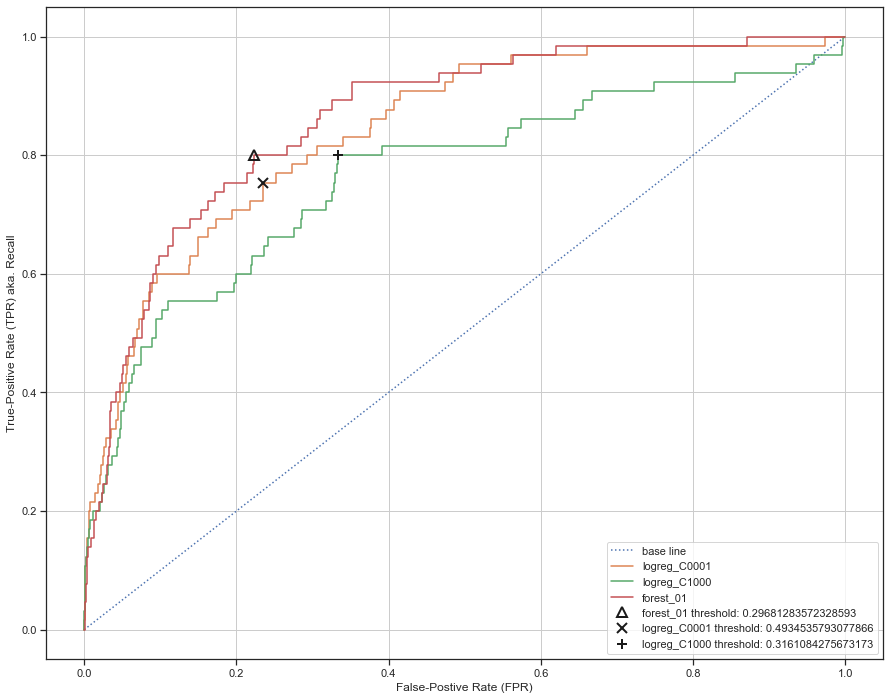

AUC for forest_01:    0.863
AUC for logreg_C0001: 0.843
AUC for logreg_C1000: 0.766
Wall time: 3.12 s


In [63]:
%%time
roc_curve_graph(X_test,
                y_test
               )

roc_auc(X_test,
        y_test
       )

# Scoring

## Score Class Probabilities (Booking: No/Yes)

In [64]:
scoring_prob     = forest_01.predict_proba(X_scoring)

scoring_prob_df  = pd.DataFrame(scoring_prob,
                                columns=["Prob_0","Prob_1"]
                               )

scoring_all_prob = (pd.merge(scoring_all,
                             scoring_prob_df,
                             left_index=True,
                             right_index=True
                            ).sort_values("Prob_1",ascending=False)
                   )

In [65]:
scoring_all_prob.head(4)

,Endkunde_NR,Kampagne_Erfass_Datum_min,Kampagne_Erfass_Datum_max,Erste_Buchung_Delta,Letzte_Buchung_Delta,Erste_Letzte_Buchung_Delta,Netto_Sum_Aus_RY_0_KW_1,Netto_Sum_Aus_RY_0_KW_11,Netto_Sum_Aus_RY_0_KW_13,Netto_Sum_Aus_RY_0_KW_15,Netto_Sum_Aus_RY_0_KW_17,Netto_Sum_Aus_RY_0_KW_19,Netto_Sum_Aus_RY_0_KW_21,Netto_Sum_Aus_RY_0_KW_23,Netto_Sum_Aus_RY_0_KW_25,Netto_Sum_Aus_RY_0_KW_27,Netto_Sum_Aus_RY_0_KW_29,Netto_Sum_Aus_RY_0_KW_3,Netto_Sum_Aus_RY_0_KW_31,Netto_Sum_Aus_RY_0_KW_33,Netto_Sum_Aus_RY_0_KW_35,Netto_Sum_Aus_RY_0_KW_37,Netto_Sum_Aus_RY_0_KW_39,Netto_Sum_Aus_RY_0_KW_41,Netto_Sum_Aus_RY_0_KW_43,Netto_Sum_Aus_RY_0_KW_45,Netto_Sum_Aus_RY_0_KW_5,Netto_Sum_Aus_RY_0_KW_7,Netto_Sum_Aus_RY_0_KW_9,Netto_Sum_Aus_RY_1_KW_1,Netto_Sum_Aus_RY_1_KW_11,Netto_Sum_Aus_RY_1_KW_13,Netto_Sum_Aus_RY_1_KW_15,Netto_Sum_Aus_RY_1_KW_17,Netto_Sum_Aus_RY_1_KW_19,Netto_Sum_Aus_RY_1_KW_21,Netto_Sum_Aus_RY_1_KW_23,Netto_Sum_Aus_RY_1_KW_25,Netto_Sum_Aus_RY_1_KW_27,Netto_Sum_Aus_RY_1_KW_29,Netto_Sum_Aus_RY_1_KW_3,Netto_Sum_Aus_RY_1_KW_31,Netto_Sum_Aus_RY_1_KW_33,Netto_Sum_Aus_RY_1_KW_35,Netto_Sum_Aus_RY_1_KW_37,Netto_Sum_Aus_RY_1_KW_39,Netto_Sum_Aus_RY_1_KW_41,Netto_Sum_Aus_RY_1_KW_43,Netto_Sum_Aus_RY_1_KW_45,Netto_Sum_Aus_RY_1_KW_47,Netto_Sum_Aus_RY_1_KW_49,Netto_Sum_Aus_RY_1_KW_5,Netto_Sum_Aus_RY_1_KW_51,Netto_Sum_Aus_RY_1_KW_7,Netto_Sum_Aus_RY_1_KW_9,Netto_Sum_Aus_RY_2_KW_1,Netto_Sum_Aus_RY_2_KW_11,Netto_Sum_Aus_RY_2_KW_13,Netto_Sum_Aus_RY_2_KW_15,Netto_Sum_Aus_RY_2_KW_17,Netto_Sum_Aus_RY_2_KW_19,Netto_Sum_Aus_RY_2_KW_21,Netto_Sum_Aus_RY_2_KW_23,Netto_Sum_Aus_RY_2_KW_25,Netto_Sum_Aus_RY_2_KW_27,Netto_Sum_Aus_RY_2_KW_29,Netto_Sum_Aus_RY_2_KW_3,Netto_Sum_Aus_RY_2_KW_31,Netto_Sum_Aus_RY_2_KW_33,Netto_Sum_Aus_RY_2_KW_35,Netto_Sum_Aus_RY_2_KW_37,Netto_Sum_Aus_RY_2_KW_39,Netto_Sum_Aus_RY_2_KW_41,Netto_Sum_Aus_RY_2_KW_43,Netto_Sum_Aus_RY_2_KW_45,Netto_Sum_Aus_RY_2_KW_47,Netto_Sum_Aus_RY_2_KW_49,Netto_Sum_Aus_RY_2_KW_5,Netto_Sum_Aus_RY_2_KW_51,Netto_Sum_Aus_RY_2_KW_7,Netto_Sum_Aus_RY_2_KW_9,Netto_Sum_Aus_RY_3_KW_1,Netto_Sum_Aus_RY_3_KW_11,Netto_Sum_Aus_RY_3_KW_13,Netto_Sum_Aus_RY_3_KW_15,Netto_Sum_Aus_RY_3_KW_17,Netto_Sum_Aus_RY_3_KW_19,Netto_Sum_Aus_RY_3_KW_21,Netto_Sum_Aus_RY_3_KW_23,Netto_Sum_Aus_RY_3_KW_25,Netto_Sum_Aus_RY_3_KW_27,Netto_Sum_Aus_RY_3_KW_29,Netto_Sum_Aus_RY_3_KW_3,Netto_Sum_Aus_RY_3_KW_31,Netto_Sum_Aus_RY_3_KW_33,Netto_Sum_Aus_RY_3_KW_35,Netto_Sum_Aus_RY_3_KW_37,Netto_Sum_Aus_RY_3_KW_39,Netto_Sum_Aus_RY_3_KW_41,Netto_Sum_Aus_RY_3_KW_43,Netto_Sum_Aus_RY_3_KW_45,Netto_Sum_Aus_RY_3_KW_47,Netto_Sum_Aus_RY_3_KW_49,Netto_Sum_Aus_RY_3_KW_5,Netto_Sum_Aus_RY_3_KW_51,Netto_Sum_Aus_RY_3_KW_7,Netto_Sum_Aus_RY_3_KW_9,Netto_Sum_Aus_RY_4_KW_47,Netto_Sum_Aus_RY_4_KW_49,Netto_Sum_Aus_RY_4_KW_51,Netto_Sum_Res_RY_0_KW_1,Netto_Sum_Res_RY_0_KW_11,Netto_Sum_Res_RY_0_KW_13,Netto_Sum_Res_RY_0_KW_15,Netto_Sum_Res_RY_0_KW_17,Netto_Sum_Res_RY_0_KW_19,Netto_Sum_Res_RY_0_KW_21,Netto_Sum_Res_RY_0_KW_23,Netto_Sum_Res_RY_0_KW_25,Netto_Sum_Res_RY_0_KW_27,Netto_Sum_Res_RY_0_KW_29,Netto_Sum_Res_RY_0_KW_3,Netto_Sum_Res_RY_0_KW_31,Netto_Sum_Res_RY_0_KW_33,Netto_Sum_Res_RY_0_KW_35,Netto_Sum_Res_RY_0_KW_37,Netto_Sum_Res_RY_0_KW_39,Netto_Sum_Res_RY_0_KW_41,Netto_Sum_Res_RY_0_KW_43,Netto_Sum_Res_RY_0_KW_45,Netto_Sum_Res_RY_0_KW_5,Netto_Sum_Res_RY_0_KW_7,Netto_Sum_Res_RY_0_KW_9,Netto_Sum_Res_RY_1_KW_1,Netto_Sum_Res_RY_1_KW_11,Netto_Sum_Res_RY_1_KW_13,Netto_Sum_Res_RY_1_KW_15,Netto_Sum_Res_RY_1_KW_17,Netto_Sum_Res_RY_1_KW_19,Netto_Sum_Res_RY_1_KW_21,Netto_Sum_Res_RY_1_KW_23,Netto_Sum_Res_RY_1_KW_25,Netto_Sum_Res_RY_1_KW_27,Netto_Sum_Res_RY_1_KW_29,Netto_Sum_Res_RY_1_KW_3,Netto_Sum_Res_RY_1_KW_31,Netto_Sum_Res_RY_1_KW_33,Netto_Sum_Res_RY_1_KW_35,Netto_Sum_Res_RY_1_KW_37,Netto_Sum_Res_RY_1_KW_39,Netto_Sum_Res_RY_1_KW_41,Netto_Sum_Res_RY_1_KW_43,Netto_Sum_Res_RY_1_KW_45,Netto_Sum_Res_RY_1_KW_47,Netto_Sum_Res_RY_1_KW_49,Netto_Sum_Res_RY_1_KW_5,Netto_Sum_Res_RY_1_KW_51,Netto_Sum_Res_RY_1_KW_7,Netto_Sum_Res_RY_1_KW_9,Netto_Sum_Res_RY_2_KW_1,Netto_Sum_Res_RY_2_KW_11,Netto_Sum_Res_RY_2_KW_1

## Backup for comparision with Rscript

In [66]:
backup_scorings_df =  scoring_all_prob.loc[:,["Endkunde_NR","Prob_1"]]

with project_dir("vkprog\\predictions"):
    store_bin(backup_scorings_df, "20191118_pred_rebuild_with_sales_filter.feather")


09:47:30 [INFO] Started storing binary file
09:47:30 [INFO] Writing to file C:\Users\stc\data\vkprog\predictions\20191118_pred_rebuild_with_sales_filter.feather
09:47:30 [INFO] Written 300.0 KB
09:47:30 [INFO] Finished storing binary file in 0.01s (0.0s CPU)


## Adding additional information for delivery lists ``EK_LIST_2W_KOMPLETT.csv``

In [67]:
from pa_lib.file import load_bin

In [68]:
ek_info = load_bin("vkprog\\ek_info.feather")

09:47:30 [INFO] Started loading binary file
09:47:30 [INFO] Reading from file C:\Users\stc\data\vkprog\ek_info.feather
09:47:30 [INFO] Finished loading binary file in 0.04s (0.05s CPU)


In [69]:
ek_list_raw = pd.merge(scoring_all_prob,ek_info,on="Endkunde_NR", how="left")

In [70]:
ek_list_raw.shape

(12786, 385)

In [71]:
# Check _col_selection_ in file "vp2xlsx.py". 
# It's the only one that actually counts! 
# Compare with R-code to figure out the meaning.

net_columns = [col for col in ek_info.columns if col.startswith("Net_")]

col_row_filter =([
    "Insolvenz",
    #"Last_Res_Date",  # covered in listing
    #"Last_Aus_Date",  # covered in listing
    "last_CRM_Ktkt_date",
    "VB_FILTER_VON",
    "VB_FILTER_BIS"
    ])

listing = (
    ["Endkunde_NR",      # Endkunde_NR
     "Endkunde",         # Endkunde
     "EK_HB_Apg_Kurzz",  # HB_APG (based on R-script)
     "Agentur",          # Agentur
     "AG_Hauptbetreuer", # HB_Agentur   
     "PLZ",              # PLZ
     "GEMEINDE"]        # Ort
    
     +net_columns       # Net_2015, Net_2016, Net_2017, Net_2018, Net_2019 
    
     +["letzte_VBs",     # (bd, aggregiert)
       "Letzter_Kontakt", # KZ_letzter_Ktkt (crm)
       "Kanal",           #(crm)
       "Betreff",         #(crm)    
       "Last_Res_Date", # Letzte_Kamp_erfasst
       "Last_Aus_Date", # letzte_Kamp_Beginn
       "VERKAUFS_GEBIETS_CODE", # Verkaufsgebiet
       "VB_VKGEB",      
       "Prob_1"        # prob_KW (from here, good good.)
       ]
    # Needed for row_filter
    + col_row_filter
    )

ek_list = (ek_list_raw
    .loc[:,listing]
    .rename(columns={
        "EK_HB_Apg_Kurzz": "HB_APG",
        "AG_Hauptbetreuer": "HB_Agentur",
        "GEMEINDE": "Ort",
        "Letzter_Kontakt": "letzter_Kontakt",
        "Last_Res_Date": "letzte_Kamp_erfasst",
        "Last_Aus_Date":"letzte_Kamp_Beginn",
        "VERKAUFS_GEBIETS_CODE": "Verkaufsgebiet",
        "VB_VKGEB": "VB_VK_Geb",
        "Prob_1": "prob_KW"
    })       
    )

print(f"ek_list.shape: {ek_list.shape}")

ek_list.shape: (12786, 25)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [72]:
ek_list.sample(10)

,Endkunde_NR,Endkunde,HB_APG,Agentur,HB_Agentur,PLZ,Ort,Net_2015,Net_2016,Net_2017,Net_2018,Net_2019,letzte_VBs,letzter_Kontakt,Kanal,Betreff,letzte_Kamp_erfasst,letzte_Kamp_Beginn,Verkaufsgebiet,VB_VK_Geb,prob_KW,Insolvenz,last_CRM_Ktkt_date,VB_FILTER_VON,VB_FILTER_BIS
2248,477059,Obrasso Classic Events GmbH,OSS,None,None,6002,Luzern,25728.0,26763.0,5585.0,6440.0,5585.0,NaN,OSS,E-Mail,Neujahrsaktion - Neujahrsaktion KW50-04 Mailing,2019-10-15,2020-01-06,V-M07,JCO,0.407010,None,2019-10-27,NaT,NaT
8989,628168,Fondazione Ticino Cuore,LPA,None,None,6900,Lugano,0.0,0.0,6412.0,0.0,0.0,NaN,LPA,E-Mail,Neujahrsaktion - Neujahrsaktion KW50-04 Mailing,2017-01-31,2017-05-22,V-S02,TRA,0.211325,None,2019-10-26,NaT,NaT
11090,569264,Humbel Spezialitätenbrennerei AG,PAL,Girod Gründisch & Partner,FGR,5608,Stetten AG,2122.0,2066.0,2137.0,2081.0,0.0,NaN,WIM,E-Mail,AW: Bestätigung 1009739 - Humbel Spezialitäten...,2018-09-06,2018-11-05,V-M06,OSS,0.128434,None,2019-09-24,NaT,NaT
11739,467035,Mesey Daniel,VIT,None,None,2052,Fontainemelon,1512.0,6507.0,0.0,2520.0,0.0,NaN,None,None,None,2018-05-03,2018-07-09,V-W04,VIT,0.104326,None,NaT,NaT,NaT
8588,607445,Curling 2006 GmbH,None,None,None,4052,Basel,19127.0,15000.0,0.0,0.0,0.0,NaN,ROF,Telefon,einmaliger Anlass,2016-04-11,2016-04-11,V-M01,RPO,0.224747,None,2017-02-02,NaT,NaT
9671,624490,Orchestre Symphonique Bande-Son,MZB,None,None,1002,Lausanne,0.0,784.0,4796.0,0.0,0.0,NaN,MZB,E-Mail,Neujahrsaktion - Neujahrsaktion KW50-04 Mailing,2017-12-08,2018-03-05,V-W03,MZB,0.181138,None,2019-10-26,NaT,NaT
12762,628092,SERVAS Schweiz,CGA,None,None,8125,Zollikerberg,0.0,0.0,249.0,0.0,0.0,NaN,None,None,None,2017-02-13,2017-06-17,V-Z01,,0.050334,None,NaT,NaT,NaT
3772,119661,Ringler Informatik AG,DCI,One Marketing Services AG,CGA,6340,Baar,0.0,0.0,0.0,31184.0,56462.0,NaN,MOE,E-Mail,Neujahrsaktion - Neujahrsaktion KW50-04 Mailing,2019-03-01,2019-04-01,"V-Z03,V-Z02",,0.350758,None,2019-10-25,NaT,NaT
5900,575309,Kimura Shukokai Karate Wetzikon GmbH,MBU,None,None,8620,Wetzikon ZH,0.0,0.0,0.0,0.0,772.0,NaN,MBU,E-Mail,Neujahrsaktion - Neujahrsaktion KW50-04 Mailing,2019-01-31,2019-03-11,V-O03,ACO,0.294831,None,2019-10-27,NaT,NaT
3401,113039,"Manor, Nordmann & Co., Luzern",JCO,None,None,6020,Emmenbrücke 3,0.0,31000.0,20000.0,20000.0,8891.0,NaN,JCO,E-Mail,Neujahrsaktion - Neujahrsaktion KW50-04 Mailing,2019-09-26,2019-11-01,V-M07,JCO,0.362534,None,2019-10-27,2019-06-25,NaT


In [73]:
desc_col(ek_list)

,DTYPE,NULLS,UNIQUE
Endkunde_NR,int64,0/12786,12786
Endkunde,object,0/12786,12184
HB_APG,object,319/12467,63
Agentur,object,7532/5254,1801
HB_Agentur,object,7576/5210,93
PLZ,int64,0/12786,2009
Ort,object,6/12780,1950
Net_2015,float64,2/12784,3675
Net_2016,float64,2/12784,4512
Net_2017,float64,2/12784,4585


## Deployment for ``vp2xlsx.py``

In [74]:
with project_dir("vkprog\\predictions"):
    store_bin(ek_list, "20191118_ek_list.feather")

09:47:31 [INFO] Started storing binary file
09:47:31 [INFO] Writing to file C:\Users\stc\data\vkprog\predictions\20191118_ek_list.feather
09:47:31 [INFO] Written 3.2 MB
09:47:31 [INFO] Finished storing binary file in 0.03s (0.16s CPU)


# Appendix

## Mutual Information

In [ ]:
%%time
mu_in = (mutual_info_classif(X_train_balanced,y_train_balanced) / mutual_info_classif(y_train_balanced.reshape(-1,1),y_train_balanced))

In [ ]:
print(mu_in.shape)
print(feature_columns.shape)

In [ ]:
 mu_in_df = (
     pd.DataFrame(
         {'Feature':           feature_columns,
          'Mutual_Information': mu_in}
         )
     .sort_values(by        = 'Mutual_Information',
                  ascending = False
                 )
     .reset_index(drop=True)
     )

In [ ]:
display(mu_in_df.head(50))

In [ ]:
boxplot_histogram(mu_in_df.loc[:,'Mutual_Information'])

In [ ]:
def mu_in_cutoff(cutoff):
    display(mu_in_df.loc[mu_in_df.loc[:,'Mutual_Information'] >= cutoff,:])

In [ ]:
mu_in_cutoff(0.07)

In [ ]:
mu_in_df['scaled'] = mu_in_df['Mutual_Information'] / mu_in_df['Mutual_Information'].sum()

In [ ]:
mu_in_df['cum'] = mu_in_df['scaled'].cumsum()

In [ ]:
plt.figure(figsize=(15,50))
sns.barplot(x   = 'Mutual_Information',
            y   = 'Feature',
            data= mu_in_df)

## Univariate Analysis

In [ ]:
for feature in feature_columns:
    print(feature)
    print(len(training_all.loc[training_all.loc[:,feature] > 0, feature]))
    boxplot_histogram(training_all.loc[training_all.loc[:,feature] > 0, feature])

## Bivariate Analysis

In [ ]:
training_all.describe()

In [ ]:
print(training_all.columns)

In [ ]:
def hexbin(dataset, first_feature,second_feature,gridsize=25):
    dataset.plot.hexbin(x=first_feature, y=second_feature , gridsize=gridsize, figsize=(12,8))

In [ ]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=10, cmap=cmap, **kwargs)

with sns.axes_style("dark"):
    g = sns.FacetGrid(training_all,
                      hue="Target_Res_flg",
                      col="Target_Res_flg",
                      height=10
                     )

g.map(hexbin,
      "Netto_Sum_Aus_RY_0_KW_1",
      "Erste_Buchung_Delta",
      extent=[0, 1, 0, 1]
     )

In [ ]:
%%time
sns.axes_style("darkgrid")

sns.pairplot(data   = training_all.loc[:,["Target_Res_flg"]+list(mu_in_df.head(20).loc[:,"Feature"])],
             diag_kind="kde",
             hue    = "Target_Res_flg",
             height =5
            ).savefig("derp.png")
